In [1]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score
import json
import matplotlib.pyplot as plt
import numpy as np
import re

In [2]:
df = pd.read_csv('demographic.csv')
df = df.drop('index', axis=1)
df

/tmp/ipykernel_170560/466465776.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('demographic.csv')


,flag_bad,de_age,de_gender,de_date_joined,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_accomodation_type,de_education,...,de_children,ph_total_contacts,ph_other_device_info,ph_call_log_stats,ph_country_code,ph_app_list,fb_gender,fb_dob,fb_last_updated_date,fb_relation
0,0,26,1,08/04/2018 14:50,2535,3000000,1,51,4,2,...,0,66,"{""device_codename"": ""HM2014817"", ""brand"": ""Xia...","{""percent_incoming_nighttime"": 1.83, ""percent_...",id,"['com.google.android.music', 'com.facebook.orc...",male,11/23/1991,2017-12-21T04:38:00+0000,Married
1,0,22,1,02/01/2018 17:17,685,4000000,1,28,4,4,...,0,69,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.google.android.instantapps.supervisor', ...",male,01/20/1995,2017-11-25T17:23:09+0000,NaN
2,1,32,1,01/01/2018 16:39,1765,7000000,1,35,4,4,...,2,315,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 6.65, ""percent_...",id,"['com.tencent.ibg.joox', 'com.mrgames.larvaact...",male,10/13/1985,2017-12-23T18:05:57+0000,Married
3,0,31,2,04/01/2018 22:36,407,20000000,3,37,4,3,...,2,84,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.kfit.fave', 'app.bpjs.mobile', 'com.redd...",female,07/27/1986,2017-12-05T09:37:19+0000,Married
4,0,27,1,02/01/2018 18:12,3064,3000000,1,36,4,3,...,0,0,"{""device_codename"": ""1609"", ""brand"": ""vivo""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.lenovo.anyshare.gps', 'com.UCMobile.intl...",male,07/05/1990,2017-12-03T09:09:48+0000,In a relationship
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,11/07/2018 22:23,997,5000000,2,51,4,2,...,2,1026,"{""device_codename"": ""A1601"", ""brand"": ""OPPO""}","{""percent_incoming_nighttime"": 5.66, ""percent_...",id,"['com.instagram.android', 'com.google.android....",NaN,NaN,NaN,NaN
41018,0,26,1,11/07/2018 20:28,955,3000000,2,24,4,2,...,0,0,"{""device_codename"": ""nikel"", ""brand"": ""Xiaomi""}","{""percent_incoming_nighttime"": 10.71, ""percent...",id,"['com.youmusic.magictiles', 'com.ayopop', 'com...",NaN,NaN,NaN,NaN
41019,0,22,2,11/07/2018 23:33,881,3000000,1,9,4,4,...,0,272,"{""device_codename"": ""a33g"", ""brand"": ""samsung""}","{""percent_incoming_nighttime"": 0.0, ""percent_o...",id,"['com.grabtaxi.passenger', 'jp.co.translimit.b...",female,10/02/1995,2017-10-25T08:05:13+0000,NaN
41020,0,29,2,11/07/2018 22:03,540,6000000,1,51,4,2,...,0,0,"{""device_codename"": ""santoni"", ""brand"": ""Xiaomi""}","{""percent_incoming_nighttime"": 1.27, ""percent_...",id,"['cn.wps.moffice_eng', 'com.vuclip.viu', 'com....",NaN,NaN,NaN,NaN


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   flag_bad                41022 non-null  int64 
 1   de_age                  41022 non-null  int64 
 2   de_gender               41022 non-null  int64 
 3   de_date_joined          41022 non-null  object
 4   de_num_friends          41022 non-null  int64 
 5   de_monthly_salary       41022 non-null  int64 
 6   de_employment_type      41022 non-null  int64 
 7   de_employment_duration  41022 non-null  int64 
 8   de_accomodation_type    41022 non-null  int64 
 9   de_education            41022 non-null  int64 
 10  de_marital_status       41022 non-null  int64 
 11  de_children             41022 non-null  int64 
 12  ph_total_contacts       41022 non-null  int64 
 13  ph_other_device_info    41022 non-null  object
 14  ph_call_log_stats       38935 non-null  object
 15  ph

In [4]:
df.isna().sum()/len(df)

flag_bad                  0.000000
de_age                    0.000000
de_gender                 0.000000
de_date_joined            0.000000
de_num_friends            0.000000
de_monthly_salary         0.000000
de_employment_type        0.000000
de_employment_duration    0.000000
de_accomodation_type      0.000000
de_education              0.000000
de_marital_status         0.000000
de_children               0.000000
ph_total_contacts         0.000000
ph_other_device_info      0.000000
ph_call_log_stats         0.050875
ph_country_code           0.000609
ph_app_list               0.000000
fb_gender                 0.036883
fb_dob                    0.235313
fb_last_updated_date      0.035834
fb_relation               0.645044
dtype: float64

Check balanceness of data

In [5]:
df.flag_bad.value_counts()/len(df)

flag_bad
0    0.870313
1    0.129687
Name: count, dtype: float64

Not really unbalanced

In [6]:
df.de_accomodation_type.value_counts()

de_accomodation_type
4    41022
Name: count, dtype: int64

In [7]:
df.ph_country_code.value_counts()

ph_country_code
id    40984
us        3
sg        3
my        2
jp        2
tw        1
kh        1
th        1
Name: count, dtype: int64

Dont use these data, it is not varied enough

# Baseline Modelling

In [335]:
df.de_employment_type.value_counts()

de_employment_type
1    29566
2     6621
3     4833
4        2
Name: count, dtype: int64

In [336]:
df.de_education.value_counts()

de_education
2    24589
4     8258
3     5758
5     1561
1      856
Name: count, dtype: int64

In [337]:
df.de_children.value_counts()

de_children
0    23095
1     8921
2     7249
3     1446
4      311
Name: count, dtype: int64

In [338]:
df.de_marital_status.value_counts()

de_marital_status
1    20154
2    20020
3      500
4      348
Name: count, dtype: int64

In [339]:
df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_total_contacts',
]].copy()
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_total_contacts
0,0,26,1,2535,3000000,1,51,2,2,0,66
1,0,22,1,685,4000000,1,28,4,1,0,69
2,1,32,1,1765,7000000,1,35,4,2,2,315
3,0,31,2,407,20000000,3,37,3,2,2,84
4,0,27,1,3064,3000000,1,36,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,1026
41018,0,26,1,955,3000000,2,24,2,1,0,0
41019,0,22,2,881,3000000,1,9,4,1,0,272
41020,0,29,2,540,6000000,1,51,2,1,0,0


In [340]:
df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   flag_bad                41022 non-null  int64 
 1   de_age                  41022 non-null  int64 
 2   de_gender               41022 non-null  object
 3   de_num_friends          41022 non-null  int64 
 4   de_monthly_salary       41022 non-null  int64 
 5   de_employment_type      41022 non-null  object
 6   de_employment_duration  41022 non-null  int64 
 7   de_education            41022 non-null  object
 8   de_marital_status       41022 non-null  object
 9   de_children             41022 non-null  object
 10  ph_total_contacts       41022 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 3.4+ MB


In [341]:
df_bs = pd.get_dummies(df_bs)

In [342]:
y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

In [343]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [344]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [345]:
y_pred = model.predict(X_test)

In [346]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      7167
           1       0.31      0.02      0.04      1038

    accuracy                           0.87      8205
   macro avg       0.59      0.51      0.49      8205
weighted avg       0.80      0.87      0.82      8205



# Second Model

Employment type 4 assign to 3 because
1. Its not provided in documentation, can be misfill
2. Only 2
3. 3 is the nearest

And we also feature eningeering month of join date

Adding fb gender also and put unstated to nan

Adding joining age feature engineered from join date assume today is the prediction. 

In [347]:
df.fb_relation.value_counts()

fb_relation
Married                                6327
Single                                 4495
In a relationship                      1847
Engaged                                 812
It's complicated                        362
In an open relationship                 158
Married (Pending)                       154
In a domestic partnership               118
Separated                               110
Divorced                                 59
Widowed                                  57
In a relationship (Pending)              28
Engaged (Pending)                        22
In a civil union                          5
In an open relationship (Pending)         3
In a domestic partnership (Pending)       3
It's complicated (Pending)                1
Name: count, dtype: int64

In [348]:
df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    # 'de_date_joined',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_total_contacts',
    # 'fb_gender',
    # 'fb_relation'
]].copy()
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_total_contacts
0,0,26,1,2535,3000000,1,51,2,2,0,66
1,0,22,1,685,4000000,1,28,4,1,0,69
2,1,32,1,1765,7000000,1,35,4,2,2,315
3,0,31,2,407,20000000,3,37,3,2,2,84
4,0,27,1,3064,3000000,1,36,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,1026
41018,0,26,1,955,3000000,2,24,2,1,0,0
41019,0,22,2,881,3000000,1,9,4,1,0,272
41020,0,29,2,540,6000000,1,51,2,1,0,0


In [349]:
df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)

In [350]:
# df_bs['de_joining_age'] = (pd.Timestamp.today() - pd.to_datetime(df_bs.de_date_joined, dayfirst=True)).dt.days

In [351]:
# df_bs['de_month'] = pd.to_datetime(df_bs.de_date_joined, dayfirst=True).dt.month
# df_bs = df_bs.drop('de_date_joined', axis=1)

In [352]:
# df_bs.fb_gender = df_bs.fb_gender.fillna("unstated")

In [353]:
df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)
# df_bs.de_month = df_bs.de_month.astype(str)
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   flag_bad                41022 non-null  int64 
 1   de_age                  41022 non-null  int64 
 2   de_gender               41022 non-null  object
 3   de_num_friends          41022 non-null  int64 
 4   de_monthly_salary       41022 non-null  int64 
 5   de_employment_type      41022 non-null  object
 6   de_employment_duration  41022 non-null  int64 
 7   de_education            41022 non-null  object
 8   de_marital_status       41022 non-null  object
 9   de_children             41022 non-null  object
 10  ph_total_contacts       41022 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 3.4+ MB


In [354]:
df_bs = pd.get_dummies(df_bs)

In [355]:
y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

In [356]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [357]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [358]:
y_pred = model.predict(X_test)

In [359]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      7167
           1       0.37      0.03      0.05      1038

    accuracy                           0.87      8205
   macro avg       0.62      0.51      0.49      8205
weighted avg       0.81      0.87      0.82      8205



In this part we try joining age, joining month, fb gender and reducing the employment type number error (4) to 3. Turns out the plain one is better.

# Third Model

In [360]:
df.ph_other_device_info

0        {"device_codename": "HM2014817", "brand": "Xia...
1            {"device_codename": "A1601", "brand": "OPPO"}
2            {"device_codename": "A1601", "brand": "OPPO"}
3            {"device_codename": "A1601", "brand": "OPPO"}
4             {"device_codename": "1609", "brand": "vivo"}
                               ...                        
41017        {"device_codename": "A1601", "brand": "OPPO"}
41018      {"device_codename": "nikel", "brand": "Xiaomi"}
41019      {"device_codename": "a33g", "brand": "samsung"}
41020    {"device_codename": "santoni", "brand": "Xiaomi"}
41021    {"device_codename": "ugglite", "brand": "xiaomi"}
Name: ph_other_device_info, Length: 41022, dtype: object

In [361]:
df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_total_contacts',
]].copy()
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_total_contacts
0,0,26,1,2535,3000000,1,51,2,2,0,66
1,0,22,1,685,4000000,1,28,4,1,0,69
2,1,32,1,1765,7000000,1,35,4,2,2,315
3,0,31,2,407,20000000,3,37,3,2,2,84
4,0,27,1,3064,3000000,1,36,3,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,1026
41018,0,26,1,955,3000000,2,24,2,1,0,0
41019,0,22,2,881,3000000,1,9,4,1,0,272
41020,0,29,2,540,6000000,1,51,2,1,0,0


In [362]:
df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
df_bs = pd.concat([df_bs, df_device], axis=1)
del df_device
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_total_contacts,device_codename,brand
0,0,26,1,2535,3000000,1,51,2,2,0,66,HM2014817,Xiaomi
1,0,22,1,685,4000000,1,28,4,1,0,69,A1601,OPPO
2,1,32,1,1765,7000000,1,35,4,2,2,315,A1601,OPPO
3,0,31,2,407,20000000,3,37,3,2,2,84,A1601,OPPO
4,0,27,1,3064,3000000,1,36,3,1,0,0,1609,vivo
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,1026,A1601,OPPO
41018,0,26,1,955,3000000,2,24,2,1,0,0,nikel,Xiaomi
41019,0,22,2,881,3000000,1,9,4,1,0,272,a33g,samsung
41020,0,29,2,540,6000000,1,51,2,1,0,0,santoni,Xiaomi


In [363]:
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   flag_bad                41022 non-null  int64 
 1   de_age                  41022 non-null  int64 
 2   de_gender               41022 non-null  int64 
 3   de_num_friends          41022 non-null  int64 
 4   de_monthly_salary       41022 non-null  int64 
 5   de_employment_type      41022 non-null  int64 
 6   de_employment_duration  41022 non-null  int64 
 7   de_education            41022 non-null  int64 
 8   de_marital_status       41022 non-null  int64 
 9   de_children             41022 non-null  int64 
 10  ph_total_contacts       41022 non-null  int64 
 11  device_codename         41022 non-null  object
 12  brand                   41022 non-null  object
dtypes: int64(11), object(2)
memory usage: 4.1+ MB


In [364]:
df_bs.device_codename.value_counts()

device_codename
mido            1879
santoni         1832
A1601           1628
rolex           1536
A37f            1413
                ... 
EVERCOSS A7B       1
D2212              1
j23g               1
htc_pmeuhl         1
X3                 1
Name: count, Length: 1041, dtype: int64

In [365]:
df_bs.brand.value_counts()

brand
Xiaomi      10008
samsung      8869
OPPO         7474
xiaomi       3756
vivo         2460
            ...  
AF9900          1
Evercoss        1
B6s             1
kyocera         1
O3              1
Name: count, Length: 133, dtype: int64

In [366]:
counts = df_bs["device_codename"].value_counts()

df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
    lambda x: x if counts[x] > 30 else "others"
)
del counts
df_bs.device_codename_grouped.value_counts()

device_codename_grouped
others       4180
mido         1879
santoni      1832
A1601        1628
rolex        1536
             ... 
X556           31
iPhone6,2      31
HWRNE          31
mlv5           31
alicee         31
Name: count, Length: 195, dtype: int64

In [367]:
counts = df_bs["brand"].value_counts()

df_bs["brand_grouped"] = df_bs["brand"].apply(
    lambda x: x if counts[x] > 25 else "others"
)
del counts
df_bs.brand_grouped.value_counts()

brand_grouped
Xiaomi        10008
samsung        8869
OPPO           7474
xiaomi         3756
vivo           2460
asus           2424
Lenovo         1483
Sony            664
Smartfren       639
lge             515
others          401
Infinix         305
Apple           296
motorola        247
HUAWEI          178
Nokia           139
Meizu           133
ADVAN           119
Coolpad         109
blackberry       82
POLYTRON         81
EVERCOSS         71
acer             63
htc              54
TCL              49
Huawei           47
Hisense          44
INFINIX          42
WIKO             41
google           40
Lava             39
DOCOMO           36
OnePlus          31
ZTE              29
docomo           28
HIMAX            26
Name: count, dtype: int64

In [368]:
df_bs = df_bs.drop(['brand', 'device_codename', 'brand_grouped'], axis=1)

In [369]:
df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)

In [370]:
df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   flag_bad                 41022 non-null  int64 
 1   de_age                   41022 non-null  int64 
 2   de_gender                41022 non-null  object
 3   de_num_friends           41022 non-null  int64 
 4   de_monthly_salary        41022 non-null  int64 
 5   de_employment_type       41022 non-null  object
 6   de_employment_duration   41022 non-null  int64 
 7   de_education             41022 non-null  object
 8   de_marital_status        41022 non-null  object
 9   de_children              41022 non-null  object
 10  ph_total_contacts        41022 non-null  int64 
 11  device_codename_grouped  41022 non-null  object
dtypes: int64(6), object(6)
memory usage: 3.8+ MB


In [371]:
df_bs = pd.get_dummies(df_bs)

In [372]:
y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

In [373]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [374]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [375]:
y_pred = model.predict(X_test)

In [376]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      7167
           1       0.49      0.03      0.05      1038

    accuracy                           0.87      8205
   macro avg       0.68      0.51      0.49      8205
weighted avg       0.83      0.87      0.82      8205



In this part we see that device codename already represent the brand, and has more rich information than brand only. And after tuning the right number of device codename categorical, we got the number that make the precision highest.

## Mini Experiment

In [377]:
from sklearn.metrics import average_precision_score

In [378]:
y_proba = model.predict_proba(X_test)[:,1]
average_precision_score(y_test, y_proba)

0.22799881440240974

In [379]:
def mini_exp_device(lim):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_total_contacts',
    ]].copy()
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts
    
    df_bs = df_bs.drop(['brand', 'device_codename'], axis=1)
    
    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier()
    model.fit(X_train, y_train)
    del X_train, y_train
    
    # y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_proba)
    }

In [380]:
results = [mini_exp_device(i) for i in range(5,205,5)]

In [381]:
df_res = pd.DataFrame(results)

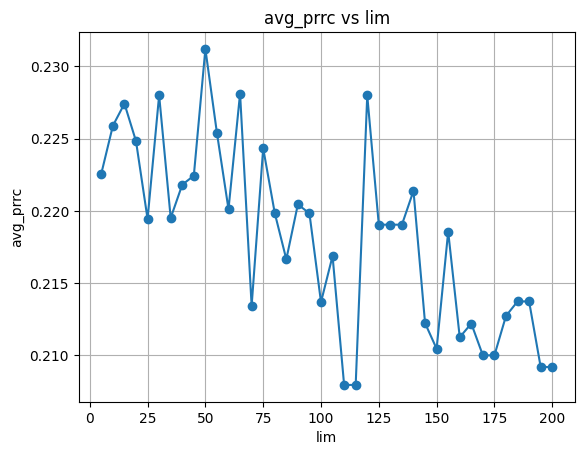

In [382]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

Our choose of 30 before has been good although not the best. Because of the trend that lower lim made it higher, we just take 30 not 120. But we may use in the next experiment.

## Mini Experiment 2

In [383]:
def mini_exp_device(lim):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_total_contacts',
    ]].copy()
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts
    
    df_bs = df_bs.drop(['brand', 'device_codename'], axis=1)
    
    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype("category")
    df_bs.de_employment_type = df_bs.de_employment_type.astype("category")
    df_bs.de_education = df_bs.de_education.astype("category")
    df_bs.de_marital_status = df_bs.de_marital_status.astype("category")
    df_bs.de_children = df_bs.de_children.astype("category")
    
    # df_bs = pd.get_dummies(df_bs)
    df_bs.device_codename_grouped = df_bs.device_codename_grouped.astype("category")
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier(enable_categorical=True)
    model.fit(X_train, y_train)
    del X_train, y_train
    
    # y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_proba)
    }

In [384]:
results = [mini_exp_device(i) for i in range(5,205,5)]

In [385]:
df_res = pd.DataFrame(results)

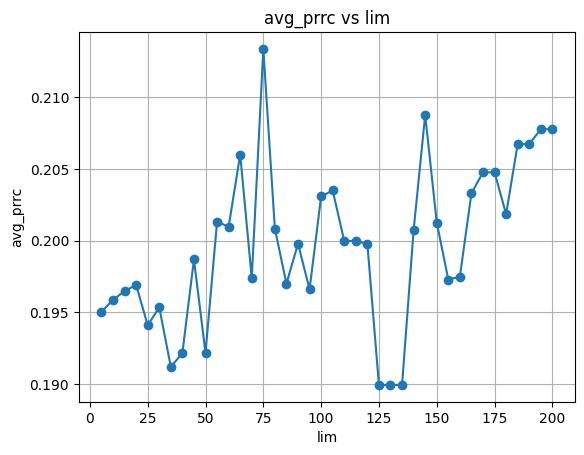

In [386]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In this experiment we use the enable categorical feature in XGBoost. The result is not much changed from before.

# Fourth Experiment

In [387]:
df.ph_call_log_stats[0]

'{"percent_incoming_nighttime": 1.83, "percent_outgoing_daytime": 28.44, "duration_incoming_daytime": 1195, "duration_outgoing_daytime": 1164, "percent_incoming_daytime": 3.67, "percent_other_calls": 2.75, "duration_outgoing_nighttime": 42358, "percent_outgoing_nighttime": 63.3, "total_calls": 109, "duration_incoming_nighttime": 293}'

In [388]:
df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_call_log_stats',
    'ph_total_contacts',
]].copy()
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_call_log_stats,ph_total_contacts
0,0,26,1,2535,3000000,1,51,2,2,0,"{""percent_incoming_nighttime"": 1.83, ""percent_...",66
1,0,22,1,685,4000000,1,28,4,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",69
2,1,32,1,1765,7000000,1,35,4,2,2,"{""percent_incoming_nighttime"": 6.65, ""percent_...",315
3,0,31,2,407,20000000,3,37,3,2,2,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",84
4,0,27,1,3064,3000000,1,36,3,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",0
...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,"{""percent_incoming_nighttime"": 5.66, ""percent_...",1026
41018,0,26,1,955,3000000,2,24,2,1,0,"{""percent_incoming_nighttime"": 10.71, ""percent...",0
41019,0,22,2,881,3000000,1,9,4,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",272
41020,0,29,2,540,6000000,1,51,2,1,0,"{""percent_incoming_nighttime"": 1.27, ""percent_...",0


In [389]:
df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
df_bs = pd.concat([df_bs, df_device], axis=1)
del df_device

In [390]:
df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
df_call_log_stats = df_call_log_stats.fillna(df_call_log_stats.median())
df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
del df_call_log_stats
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,...,percent_incoming_nighttime,percent_outgoing_daytime,duration_incoming_daytime,duration_outgoing_daytime,percent_incoming_daytime,percent_other_calls,duration_outgoing_nighttime,percent_outgoing_nighttime,total_calls,duration_incoming_nighttime
0,0,26,1,2535,3000000,1,51,2,2,0,...,1.83,28.44,1195.0,1164.0,3.67,2.75,42358.0,63.30,109.0,293.0
1,0,22,1,685,4000000,1,28,4,1,0,...,0.00,100.00,0.0,0.0,0.00,0.00,0.0,0.00,2.0,0.0
2,1,32,1,1765,7000000,1,35,4,2,2,...,6.65,41.76,5212.0,5490.0,13.56,13.30,2911.0,24.73,376.0,1846.0
3,0,31,2,407,20000000,3,37,3,2,2,...,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0
4,0,27,1,3064,3000000,1,36,3,1,0,...,0.00,46.67,0.0,14.0,0.00,0.00,84.0,53.33,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,...,5.66,42.42,7960.0,7889.0,22.22,13.74,2356.0,15.96,495.0,1786.0
41018,0,26,1,955,3000000,2,24,2,1,0,...,10.71,42.86,465.0,322.0,17.86,10.71,305.0,17.86,56.0,123.0
41019,0,22,2,881,3000000,1,9,4,1,0,...,0.00,43.75,1190.0,74.0,16.67,14.58,21.0,25.00,48.0,0.0
41020,0,29,2,540,6000000,1,51,2,1,0,...,1.27,40.13,3081.0,405.0,22.93,31.21,170.0,4.46,157.0,8.0


In [391]:
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flag_bad                     41022 non-null  int64  
 1   de_age                       41022 non-null  int64  
 2   de_gender                    41022 non-null  int64  
 3   de_num_friends               41022 non-null  int64  
 4   de_monthly_salary            41022 non-null  int64  
 5   de_employment_type           41022 non-null  int64  
 6   de_employment_duration       41022 non-null  int64  
 7   de_education                 41022 non-null  int64  
 8   de_marital_status            41022 non-null  int64  
 9   de_children                  41022 non-null  int64  
 10  ph_call_log_stats            38935 non-null  object 
 11  ph_total_contacts            41022 non-null  int64  
 12  device_codename              41022 non-null  object 
 13  brand           

In [392]:
counts = df_bs["device_codename"].value_counts()

df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
    lambda x: x if counts[x] > 150 else "others"
)
del counts

In [393]:
df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats'], axis=1)

In [394]:
df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)

In [395]:
df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 22 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flag_bad                     41022 non-null  int64  
 1   de_age                       41022 non-null  int64  
 2   de_gender                    41022 non-null  object 
 3   de_num_friends               41022 non-null  int64  
 4   de_monthly_salary            41022 non-null  int64  
 5   de_employment_type           41022 non-null  object 
 6   de_employment_duration       41022 non-null  int64  
 7   de_education                 41022 non-null  object 
 8   de_marital_status            41022 non-null  object 
 9   de_children                  41022 non-null  object 
 10  ph_total_contacts            41022 non-null  int64  
 11  percent_incoming_nighttime   41022 non-null  float64
 12  percent_outgoing_daytime     41022 non-null  float64
 13  duration_incomin

In [396]:
df_bs = pd.get_dummies(df_bs)

In [397]:
y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

In [398]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [399]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [400]:
y_pred = model.predict(X_test)

In [401]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      7167
           1       0.51      0.07      0.12      1038

    accuracy                           0.87      8205
   macro avg       0.70      0.53      0.52      8205
weighted avg       0.83      0.87      0.83      8205



In [402]:
y_proba = model.predict_proba(X_test)[:,1]
average_precision_score(y_test, y_proba)

0.2516680864820531

Based on optimization experiment below, we can fill lim with 25 if filled with 0 or 150 if filled with median

## Mini Exp Fill with 0 or median

In [403]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
    ]].copy()
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats'], axis=1)
    
    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier()
    model.fit(X_train, y_train)
    del X_train, y_train
    
    # y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_proba)
    }

In [404]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [405]:
df_res = pd.DataFrame(results)

In [406]:
df_res.head()

,lim,avg_prrc
0,5,0.246457
1,10,0.250423
2,15,0.245590
3,20,0.248429
4,25,0.258291


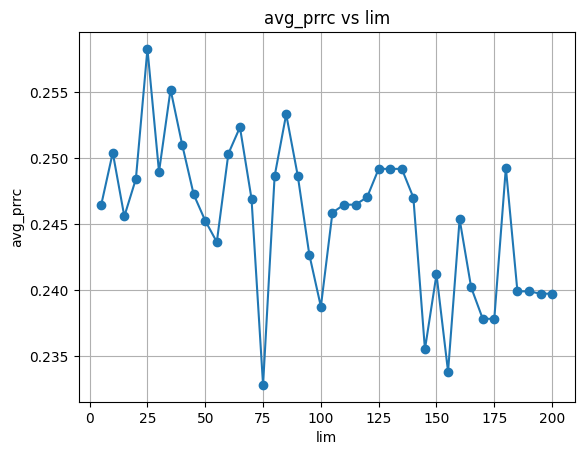

In [407]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [408]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [409]:
df_res = pd.DataFrame(results)

In [410]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.248584
26,135,0.248584
27,140,0.242302
28,145,0.245083
29,150,0.251668


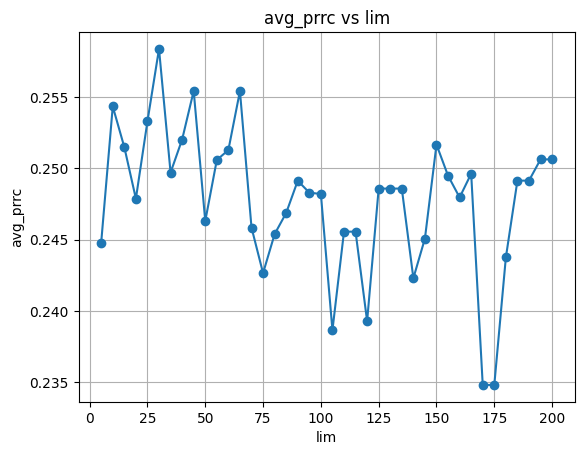

In [411]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [412]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [413]:
df_res = pd.DataFrame(results)

In [414]:
df_res[15:20]

,lim,avg_prrc
15,80,0.254975
16,85,0.255364
17,90,0.250728
18,95,0.252726
19,100,0.250252


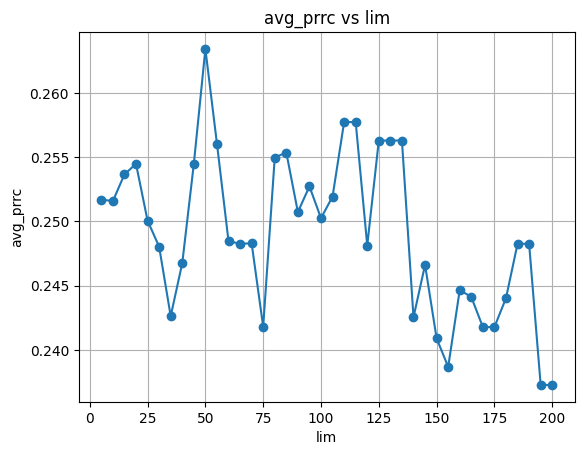

In [415]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [464]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [466]:
df_res = pd.DataFrame(results)

In [468]:
df_res[20:25]

,lim,avg_prrc
20,105,0.244465
21,110,0.240364
22,115,0.240364
23,120,0.240708
24,125,0.247583


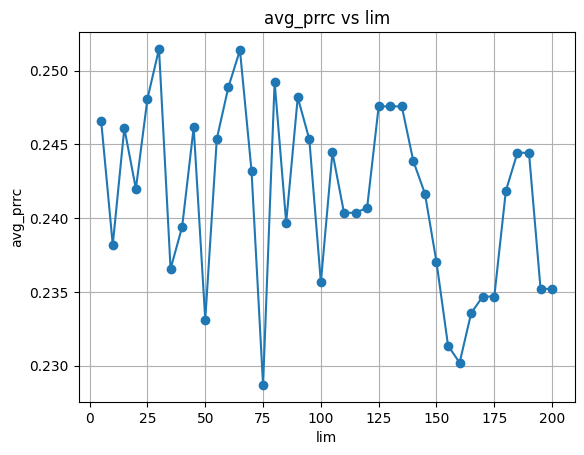

In [470]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# Fifth Experiment

Here we assume the fb last updated date is recorded when he joined. The idea is we can know how long he has been inactive since it. In there we treat nan as information also and we assume there's no update on the FB.

In [472]:
df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_call_log_stats',
    'ph_total_contacts',
    'de_date_joined',
    'fb_last_updated_date'
]].copy()
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_call_log_stats,ph_total_contacts,de_date_joined,fb_last_updated_date
0,0,26,1,2535,3000000,1,51,2,2,0,"{""percent_incoming_nighttime"": 1.83, ""percent_...",66,08/04/2018 14:50,2017-12-21T04:38:00+0000
1,0,22,1,685,4000000,1,28,4,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",69,02/01/2018 17:17,2017-11-25T17:23:09+0000
2,1,32,1,1765,7000000,1,35,4,2,2,"{""percent_incoming_nighttime"": 6.65, ""percent_...",315,01/01/2018 16:39,2017-12-23T18:05:57+0000
3,0,31,2,407,20000000,3,37,3,2,2,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",84,04/01/2018 22:36,2017-12-05T09:37:19+0000
4,0,27,1,3064,3000000,1,36,3,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",0,02/01/2018 18:12,2017-12-03T09:09:48+0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,"{""percent_incoming_nighttime"": 5.66, ""percent_...",1026,11/07/2018 22:23,NaN
41018,0,26,1,955,3000000,2,24,2,1,0,"{""percent_incoming_nighttime"": 10.71, ""percent...",0,11/07/2018 20:28,NaN
41019,0,22,2,881,3000000,1,9,4,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",272,11/07/2018 23:33,2017-10-25T08:05:13+0000
41020,0,29,2,540,6000000,1,51,2,1,0,"{""percent_incoming_nighttime"": 1.27, ""percent_...",0,11/07/2018 22:03,NaN


In [474]:
joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")

df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
del joined, updated

In [476]:
df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
df_bs = pd.concat([df_bs, df_device], axis=1)
del df_device

In [478]:
df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
df_call_log_stats = df_call_log_stats.fillna(0)
df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
del df_call_log_stats
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,...,percent_incoming_nighttime,percent_outgoing_daytime,duration_incoming_daytime,duration_outgoing_daytime,percent_incoming_daytime,percent_other_calls,duration_outgoing_nighttime,percent_outgoing_nighttime,total_calls,duration_incoming_nighttime
0,0,26,1,2535,3000000,1,51,2,2,0,...,1.83,28.44,1195.0,1164.0,3.67,2.75,42358.0,63.30,109.0,293.0
1,0,22,1,685,4000000,1,28,4,1,0,...,0.00,100.00,0.0,0.0,0.00,0.00,0.0,0.00,2.0,0.0
2,1,32,1,1765,7000000,1,35,4,2,2,...,6.65,41.76,5212.0,5490.0,13.56,13.30,2911.0,24.73,376.0,1846.0
3,0,31,2,407,20000000,3,37,3,2,2,...,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0
4,0,27,1,3064,3000000,1,36,3,1,0,...,0.00,46.67,0.0,14.0,0.00,0.00,84.0,53.33,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,...,5.66,42.42,7960.0,7889.0,22.22,13.74,2356.0,15.96,495.0,1786.0
41018,0,26,1,955,3000000,2,24,2,1,0,...,10.71,42.86,465.0,322.0,17.86,10.71,305.0,17.86,56.0,123.0
41019,0,22,2,881,3000000,1,9,4,1,0,...,0.00,43.75,1190.0,74.0,16.67,14.58,21.0,25.00,48.0,0.0
41020,0,29,2,540,6000000,1,51,2,1,0,...,1.27,40.13,3081.0,405.0,22.93,31.21,170.0,4.46,157.0,8.0


In [480]:
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flag_bad                     41022 non-null  int64  
 1   de_age                       41022 non-null  int64  
 2   de_gender                    41022 non-null  int64  
 3   de_num_friends               41022 non-null  int64  
 4   de_monthly_salary            41022 non-null  int64  
 5   de_employment_type           41022 non-null  int64  
 6   de_employment_duration       41022 non-null  int64  
 7   de_education                 41022 non-null  int64  
 8   de_marital_status            41022 non-null  int64  
 9   de_children                  41022 non-null  int64  
 10  ph_call_log_stats            38935 non-null  object 
 11  ph_total_contacts            41022 non-null  int64  
 12  de_date_joined               41022 non-null  object 
 13  fb_last_updated_

In [482]:
counts = df_bs["device_codename"].value_counts()

df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
    lambda x: x if counts[x] > 85 else "others"
)
del counts

In [484]:
df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date'], axis=1)

In [487]:
df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)

In [488]:
df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flag_bad                     41022 non-null  int64  
 1   de_age                       41022 non-null  int64  
 2   de_gender                    41022 non-null  object 
 3   de_num_friends               41022 non-null  int64  
 4   de_monthly_salary            41022 non-null  int64  
 5   de_employment_type           41022 non-null  object 
 6   de_employment_duration       41022 non-null  int64  
 7   de_education                 41022 non-null  object 
 8   de_marital_status            41022 non-null  object 
 9   de_children                  41022 non-null  object 
 10  ph_total_contacts            41022 non-null  int64  
 11  date_diff                    39552 non-null  float64
 12  percent_incoming_nighttime   41022 non-null  float64
 13  percent_outgoing

In [489]:
df_bs = pd.get_dummies(df_bs)

In [490]:
y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

In [491]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [492]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [493]:
y_pred = model.predict(X_test)

In [494]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      7167
           1       0.53      0.07      0.12      1038

    accuracy                           0.87      8205
   macro avg       0.71      0.53      0.53      8205
weighted avg       0.84      0.87      0.83      8205



In [495]:
y_proba = model.predict_proba(X_test)[:,1]
average_precision_score(y_test, y_proba)

0.24336589212634416

It increased but looking at the mini experiment, mostly its not increasing. So in the next experiment we may not include it and look at another feature experimentation first (continue from fourth experiment again)

## Mini Experiment

In [496]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
    ]].copy()

    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier()
    model.fit(X_train, y_train)
    del X_train, y_train
    
    # y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_proba)
    }

In [497]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [498]:
df_res = pd.DataFrame(results)

In [499]:
df_res.head()

,lim,avg_prrc
0,5,0.246345
1,10,0.241441
2,15,0.246369
3,20,0.247376
4,25,0.249116


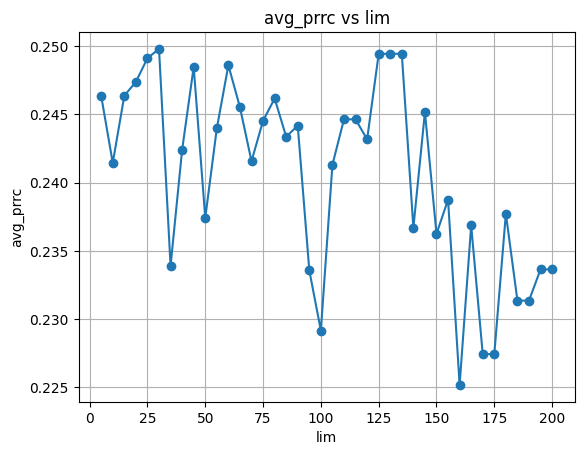

In [500]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [501]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [502]:
df_res = pd.DataFrame(results)

In [503]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.248960
26,135,0.248960
27,140,0.248591
28,145,0.242648
29,150,0.231071


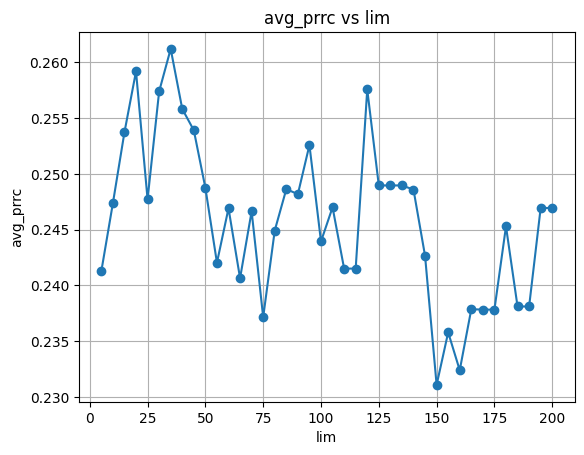

In [504]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [505]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [506]:
df_res = pd.DataFrame(results)

In [507]:
df_res[15:20]

,lim,avg_prrc
15,80,0.249088
16,85,0.253132
17,90,0.253541
18,95,0.254942
19,100,0.245983


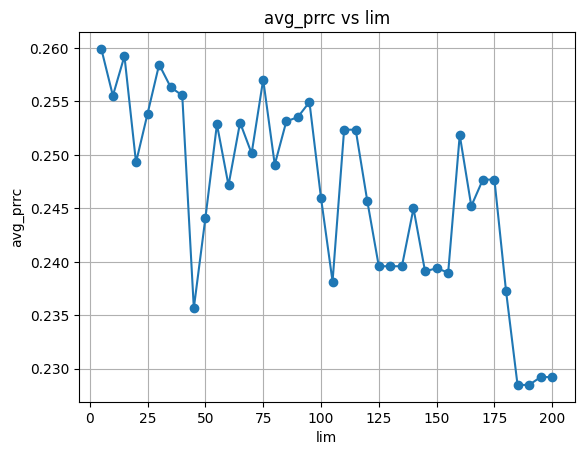

In [508]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [509]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [510]:
df_res = pd.DataFrame(results)

In [511]:
df_res[20:25]

,lim,avg_prrc
20,105,0.244465
21,110,0.240364
22,115,0.240364
23,120,0.240708
24,125,0.247583


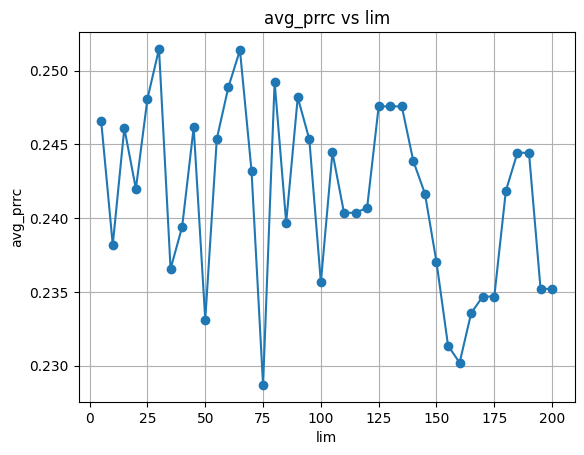

In [512]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# Sixth Experiment

In [513]:
import ast
allde = set([app for sublist in df['ph_app_list'].dropna().apply(ast.literal_eval) for app in sublist])
len(allde)

85014

We have 85014 unique apps across all these users. We can feature engineering it by tagging specific keyword like slot, casino, or even another bnpl app. Lets convert to csv to be analyzed.

In [514]:
from collections import Counter

all_apps = df['ph_app_list'].dropna().apply(ast.literal_eval)
freq = Counter(app for sublist in all_apps for app in sublist)

app_counts = pd.DataFrame(freq.items(), columns=["app", "count_users"]).sort_values("count_users", ascending=False)

In [515]:
app_counts.to_csv("app_counts.csv", index=False)

In [516]:
df_bs = df[[
    'flag_bad',
    'de_age',
    'de_gender',
    'de_num_friends',
    'de_monthly_salary',
    'de_employment_type',
    'de_employment_duration',
    'de_education',
    'de_marital_status',
    'de_children',
    'ph_call_log_stats',
    'ph_total_contacts',
    'de_date_joined',
    'fb_last_updated_date',
    'ph_app_list'
]].copy()
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,ph_call_log_stats,ph_total_contacts,de_date_joined,fb_last_updated_date,ph_app_list
0,0,26,1,2535,3000000,1,51,2,2,0,"{""percent_incoming_nighttime"": 1.83, ""percent_...",66,08/04/2018 14:50,2017-12-21T04:38:00+0000,"['com.google.android.music', 'com.facebook.orc..."
1,0,22,1,685,4000000,1,28,4,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",69,02/01/2018 17:17,2017-11-25T17:23:09+0000,"['com.google.android.instantapps.supervisor', ..."
2,1,32,1,1765,7000000,1,35,4,2,2,"{""percent_incoming_nighttime"": 6.65, ""percent_...",315,01/01/2018 16:39,2017-12-23T18:05:57+0000,"['com.tencent.ibg.joox', 'com.mrgames.larvaact..."
3,0,31,2,407,20000000,3,37,3,2,2,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",84,04/01/2018 22:36,2017-12-05T09:37:19+0000,"['com.kfit.fave', 'app.bpjs.mobile', 'com.redd..."
4,0,27,1,3064,3000000,1,36,3,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",0,02/01/2018 18:12,2017-12-03T09:09:48+0000,"['com.lenovo.anyshare.gps', 'com.UCMobile.intl..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,"{""percent_incoming_nighttime"": 5.66, ""percent_...",1026,11/07/2018 22:23,NaN,"['com.instagram.android', 'com.google.android...."
41018,0,26,1,955,3000000,2,24,2,1,0,"{""percent_incoming_nighttime"": 10.71, ""percent...",0,11/07/2018 20:28,NaN,"['com.youmusic.magictiles', 'com.ayopop', 'com..."
41019,0,22,2,881,3000000,1,9,4,1,0,"{""percent_incoming_nighttime"": 0.0, ""percent_o...",272,11/07/2018 23:33,2017-10-25T08:05:13+0000,"['com.grabtaxi.passenger', 'jp.co.translimit.b..."
41020,0,29,2,540,6000000,1,51,2,1,0,"{""percent_incoming_nighttime"": 1.27, ""percent_...",0,11/07/2018 22:03,NaN,"['cn.wps.moffice_eng', 'com.vuclip.viu', 'com...."


In [517]:
import re

categories = {
    "gambling": ["poker", "casino", "slot", "jackpot", "toto", "lotto","bet","bingo","blackjack","roulette","rummy","777","satta"],
    "clone": ["clone", "dual", "parallel", "multi", "cloner", "whatscan"],
    "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
    "finance_risky": ["loan", "cash", "kredit", "rupiah", "payday", "utang", "pinjaman", "fastcash", "moneycash", "cashloan"],
    "adult": ["live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
    "suspicious_utility": ["booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
}

# Create binary columns for each category
for cat, keywords in categories.items():
    df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
        lambda x: int(any(kw in x for kw in keywords))
    )

df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,...,ph_total_contacts,de_date_joined,fb_last_updated_date,ph_app_list,gambling,clone,modded,finance_risky,adult,suspicious_utility
0,0,26,1,2535,3000000,1,51,2,2,0,...,66,08/04/2018 14:50,2017-12-21T04:38:00+0000,"['com.google.android.music', 'com.facebook.orc...",0,1,0,0,0,0
1,0,22,1,685,4000000,1,28,4,1,0,...,69,02/01/2018 17:17,2017-11-25T17:23:09+0000,"['com.google.android.instantapps.supervisor', ...",1,0,1,0,0,0
2,1,32,1,1765,7000000,1,35,4,2,2,...,315,01/01/2018 16:39,2017-12-23T18:05:57+0000,"['com.tencent.ibg.joox', 'com.mrgames.larvaact...",1,1,0,0,1,1
3,0,31,2,407,20000000,3,37,3,2,2,...,84,04/01/2018 22:36,2017-12-05T09:37:19+0000,"['com.kfit.fave', 'app.bpjs.mobile', 'com.redd...",1,0,0,1,0,0
4,0,27,1,3064,3000000,1,36,3,1,0,...,0,02/01/2018 18:12,2017-12-03T09:09:48+0000,"['com.lenovo.anyshare.gps', 'com.UCMobile.intl...",0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,...,1026,11/07/2018 22:23,NaN,"['com.instagram.android', 'com.google.android....",1,0,0,0,1,0
41018,0,26,1,955,3000000,2,24,2,1,0,...,0,11/07/2018 20:28,NaN,"['com.youmusic.magictiles', 'com.ayopop', 'com...",0,1,0,0,1,0
41019,0,22,2,881,3000000,1,9,4,1,0,...,272,11/07/2018 23:33,2017-10-25T08:05:13+0000,"['com.grabtaxi.passenger', 'jp.co.translimit.b...",0,0,1,0,1,0
41020,0,29,2,540,6000000,1,51,2,1,0,...,0,11/07/2018 22:03,NaN,"['cn.wps.moffice_eng', 'com.vuclip.viu', 'com....",0,0,0,0,1,0


In [518]:
joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")

df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
del joined, updated

In [519]:
df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
df_bs = pd.concat([df_bs, df_device], axis=1)
del df_device

In [520]:
df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
df_call_log_stats = df_call_log_stats.fillna(0)
df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
del df_call_log_stats
df_bs

,flag_bad,de_age,de_gender,de_num_friends,de_monthly_salary,de_employment_type,de_employment_duration,de_education,de_marital_status,de_children,...,percent_incoming_nighttime,percent_outgoing_daytime,duration_incoming_daytime,duration_outgoing_daytime,percent_incoming_daytime,percent_other_calls,duration_outgoing_nighttime,percent_outgoing_nighttime,total_calls,duration_incoming_nighttime
0,0,26,1,2535,3000000,1,51,2,2,0,...,1.83,28.44,1195.0,1164.0,3.67,2.75,42358.0,63.30,109.0,293.0
1,0,22,1,685,4000000,1,28,4,1,0,...,0.00,100.00,0.0,0.0,0.00,0.00,0.0,0.00,2.0,0.0
2,1,32,1,1765,7000000,1,35,4,2,2,...,6.65,41.76,5212.0,5490.0,13.56,13.30,2911.0,24.73,376.0,1846.0
3,0,31,2,407,20000000,3,37,3,2,2,...,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0
4,0,27,1,3064,3000000,1,36,3,1,0,...,0.00,46.67,0.0,14.0,0.00,0.00,84.0,53.33,15.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41017,0,27,2,997,5000000,2,51,2,2,2,...,5.66,42.42,7960.0,7889.0,22.22,13.74,2356.0,15.96,495.0,1786.0
41018,0,26,1,955,3000000,2,24,2,1,0,...,10.71,42.86,465.0,322.0,17.86,10.71,305.0,17.86,56.0,123.0
41019,0,22,2,881,3000000,1,9,4,1,0,...,0.00,43.75,1190.0,74.0,16.67,14.58,21.0,25.00,48.0,0.0
41020,0,29,2,540,6000000,1,51,2,1,0,...,1.27,40.13,3081.0,405.0,22.93,31.21,170.0,4.46,157.0,8.0


In [521]:
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flag_bad                     41022 non-null  int64  
 1   de_age                       41022 non-null  int64  
 2   de_gender                    41022 non-null  int64  
 3   de_num_friends               41022 non-null  int64  
 4   de_monthly_salary            41022 non-null  int64  
 5   de_employment_type           41022 non-null  int64  
 6   de_employment_duration       41022 non-null  int64  
 7   de_education                 41022 non-null  int64  
 8   de_marital_status            41022 non-null  int64  
 9   de_children                  41022 non-null  int64  
 10  ph_call_log_stats            38935 non-null  object 
 11  ph_total_contacts            41022 non-null  int64  
 12  de_date_joined               41022 non-null  object 
 13  fb_last_updated_

In [522]:
counts = df_bs["device_codename"].value_counts()

df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
    lambda x: x if counts[x] > 10 else "others"
)
del counts

In [523]:
df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list'], axis=1)

In [524]:
df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)

In [525]:
df_bs.de_gender = df_bs.de_gender.astype(str)
df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
df_bs.de_education = df_bs.de_education.astype(str)
df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
df_bs.de_children = df_bs.de_children.astype(str)
df_bs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41022 entries, 0 to 41021
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   flag_bad                     41022 non-null  int64  
 1   de_age                       41022 non-null  int64  
 2   de_gender                    41022 non-null  object 
 3   de_num_friends               41022 non-null  int64  
 4   de_monthly_salary            41022 non-null  int64  
 5   de_employment_type           41022 non-null  object 
 6   de_employment_duration       41022 non-null  int64  
 7   de_education                 41022 non-null  object 
 8   de_marital_status            41022 non-null  object 
 9   de_children                  41022 non-null  object 
 10  ph_total_contacts            41022 non-null  int64  
 11  gambling                     41022 non-null  int64  
 12  clone                        41022 non-null  int64  
 13  modded          

In [526]:
df_bs = pd.get_dummies(df_bs)

In [527]:
y = df_bs.flag_bad
X = df_bs.drop('flag_bad', axis=1)

In [528]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [529]:
model = XGBClassifier()
model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [530]:
y_pred = model.predict(X_test)

In [531]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93      7167
           1       0.50      0.12      0.19      1038

    accuracy                           0.87      8205
   macro avg       0.69      0.55      0.56      8205
weighted avg       0.84      0.87      0.84      8205



In [532]:
y_proba = model.predict_proba(X_test)[:,1]
average_precision_score(y_test, y_proba)

0.3089972196227186

## Mini Experiment

In [533]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
    ]].copy()

    categories = {
        "gambling": ["poker", "casino", "slot", "jackpot", "toto", "lotto","bet","bingo","blackjack","roulette","rummy","777","satta"],
        "clone": ["clone", "dual", "parallel", "multi", "cloner", "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ["loan", "cash", "kredit", "rupiah", "payday", "utang", "pinjaman", "fastcash", "moneycash", "cashloan"],
        "adult": ["live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ["booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier()
    model.fit(X_train, y_train)
    del X_train, y_train
    
    # y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_proba)
    }

In [534]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [535]:
df_res = pd.DataFrame(results)

In [536]:
df_res.head()

,lim,avg_prrc
0,5,0.301656
1,10,0.308997
2,15,0.312801
3,20,0.296982
4,25,0.305884


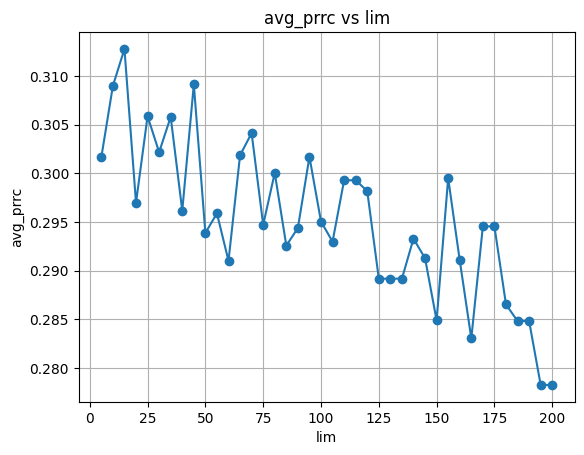

In [537]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [538]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [539]:
df_res = pd.DataFrame(results)

In [540]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.295479
26,135,0.295479
27,140,0.299745
28,145,0.292634
29,150,0.299647


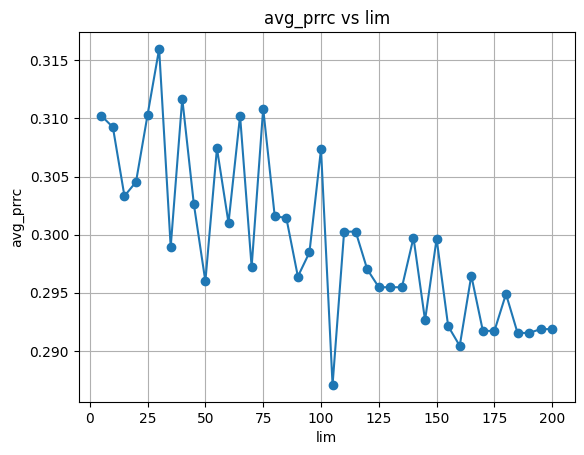

In [541]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [542]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [543]:
df_res = pd.DataFrame(results)

In [544]:
df_res[15:20]

,lim,avg_prrc
15,80,0.302329
16,85,0.308023
17,90,0.297163
18,95,0.305038
19,100,0.306076


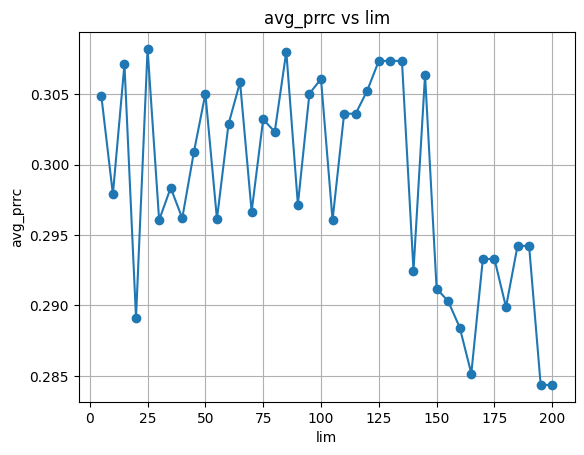

In [545]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [546]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [547]:
df_res = pd.DataFrame(results)

In [548]:
df_res[20:25]

,lim,avg_prrc
20,105,0.303227
21,110,0.311831
22,115,0.311831
23,120,0.301695
24,125,0.305531


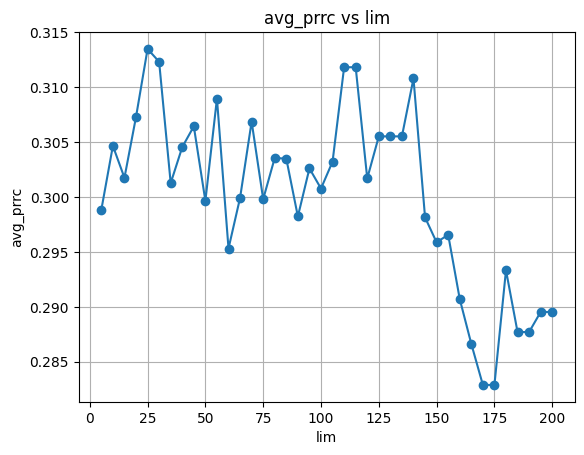

In [549]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# Seventh Experiment

In [550]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
    ]].copy()

    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier(
        # tree_method="hist",  # use histogram, works for both CPU and GPU
        # device="cuda:0"      # instead of gpu_id
    )
    model.fit(X_train, y_train)
    del X_train, y_train
    
    # y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_proba)
    }

In [551]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [552]:
df_res = pd.DataFrame(results)

In [553]:
df_res.head()

,lim,avg_prrc
0,5,0.299546
1,10,0.300085
2,15,0.295944
3,20,0.297306
4,25,0.302851


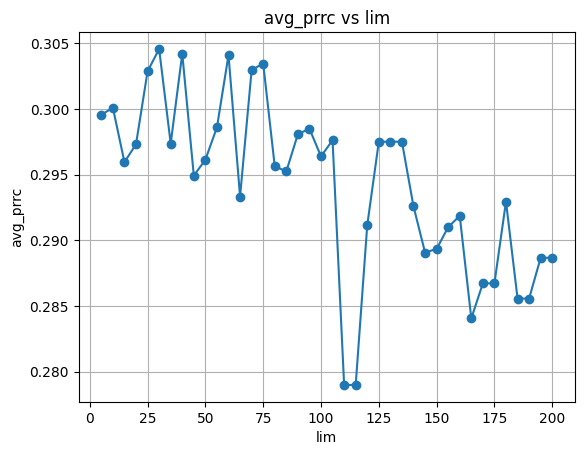

In [554]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [555]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [556]:
df_res = pd.DataFrame(results)

In [557]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.306273
26,135,0.306273
27,140,0.303787
28,145,0.292121
29,150,0.283692


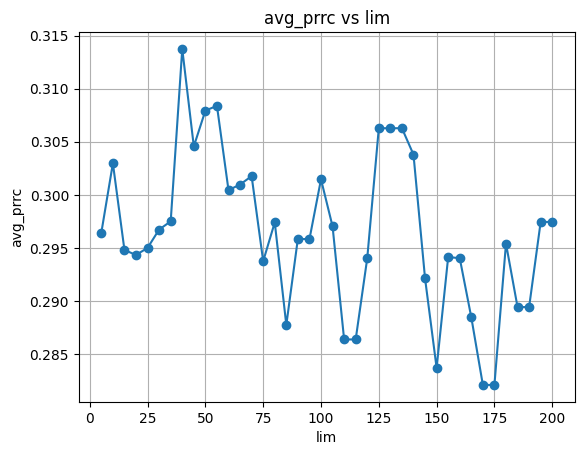

In [558]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [559]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [560]:
df_res = pd.DataFrame(results)

In [561]:
df_res[5:10]

,lim,avg_prrc
5,30,0.310686
6,35,0.305371
7,40,0.304874
8,45,0.295758
9,50,0.303089


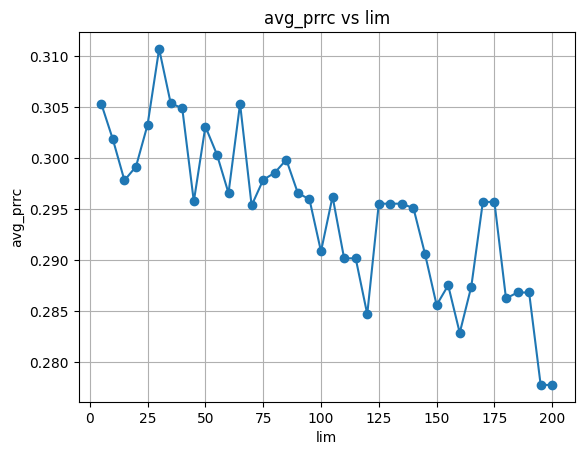

In [562]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [563]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [564]:
df_res = pd.DataFrame(results)

In [565]:
df_res[-5:]

,lim,avg_prrc
35,180,0.290162
36,185,0.300289
37,190,0.300289
38,195,0.288405
39,200,0.288405


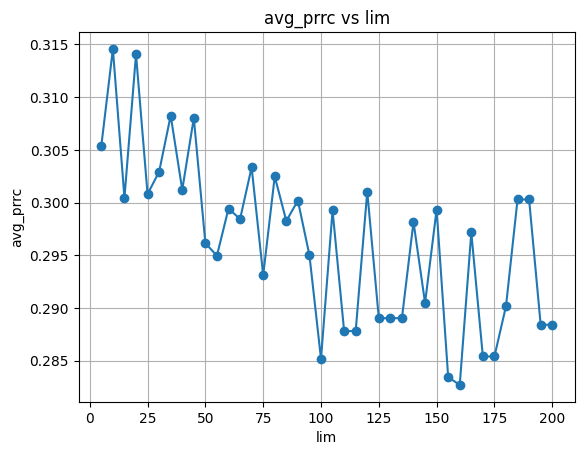

In [566]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# Eighth Experiment

Now the idea coming from fb age. Is he lying about his age or not? Unstated also counted, can be indication too.

In [567]:
df.de_age.describe()

count    41022.000000
mean        28.170908
std          6.537795
min         18.000000
25%         23.000000
50%         27.000000
75%         32.000000
max         73.000000
Name: de_age, dtype: float64

In [568]:
(((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365).describe()

count    31369.000000
mean        29.359470
std          9.984007
min         13.492192
25%         23.824612
50%         27.309433
75%         32.209488
max        113.547666
dtype: float64

In [569]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
        'fb_dob'
    ]].copy()

    df_bs['fb_age'] = ((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365
    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list', 'fb_dob'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier(
        # tree_method="hist",  # use histogram, works for both CPU and GPU
        # device="cuda:0"      # instead of gpu_id
    )
    model.fit(X_train, y_train)
    del X_train, y_train
    
    # y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_proba)
    }

In [570]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [571]:
df_res = pd.DataFrame(results)

In [572]:
df_res.head()

,lim,avg_prrc
0,5,0.291016
1,10,0.297563
2,15,0.301666
3,20,0.302052
4,25,0.301780


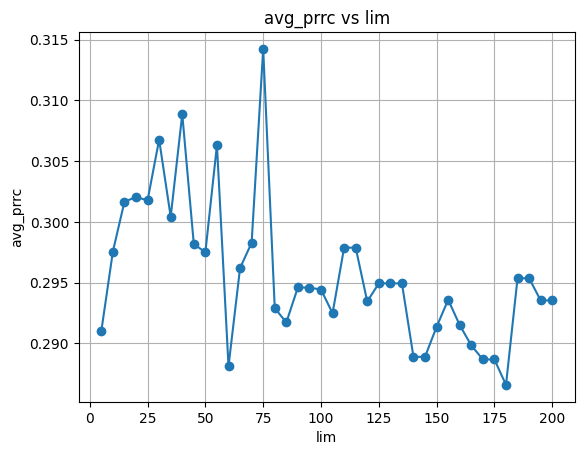

In [573]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [574]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [575]:
df_res = pd.DataFrame(results)

In [576]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.298580
26,135,0.298580
27,140,0.295744
28,145,0.294827
29,150,0.296881


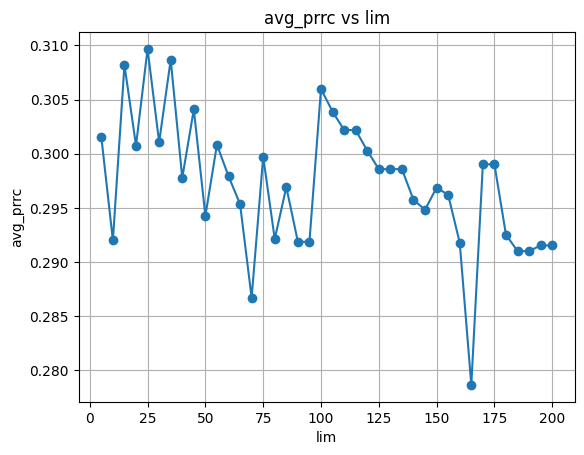

In [577]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [578]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [579]:
df_res = pd.DataFrame(results)

In [580]:
df_res[5:10]

,lim,avg_prrc
5,30,0.305264
6,35,0.304678
7,40,0.293550
8,45,0.297094
9,50,0.301882


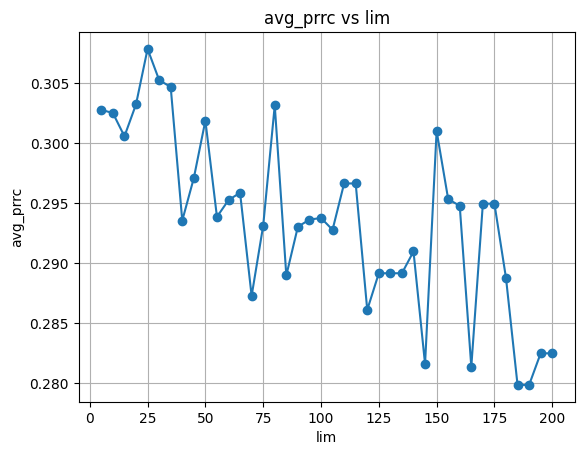

In [581]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [582]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [583]:
df_res = pd.DataFrame(results)

In [584]:
df_res[-5:]

,lim,avg_prrc
35,180,0.298429
36,185,0.282439
37,190,0.282439
38,195,0.284783
39,200,0.284783


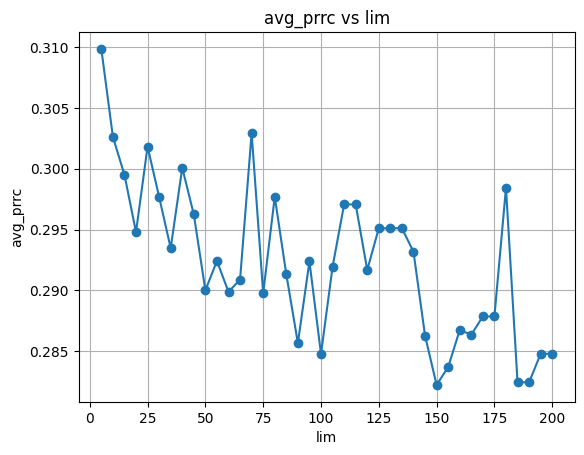

In [585]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# Ninth Experiment

Here the idea is we guess that pending status in facebook is something that needs to be tracked, because its not verified by the other partner.

In [586]:
df.fb_relation.value_counts()

fb_relation
Married                                6327
Single                                 4495
In a relationship                      1847
Engaged                                 812
It's complicated                        362
In an open relationship                 158
Married (Pending)                       154
In a domestic partnership               118
Separated                               110
Divorced                                 59
Widowed                                  57
In a relationship (Pending)              28
Engaged (Pending)                        22
In a civil union                          5
In an open relationship (Pending)         3
In a domestic partnership (Pending)       3
It's complicated (Pending)                1
Name: count, dtype: int64

In [587]:
df.fb_relation.str.contains('Pending').value_counts()

fb_relation
False    14350
True       211
Name: count, dtype: int64

In [588]:
df.fb_relation.str.replace(' (Pending)', '').value_counts()

fb_relation
Married                      6481
Single                       4495
In a relationship            1875
Engaged                       834
It's complicated              363
In an open relationship       161
In a domestic partnership     121
Separated                     110
Divorced                       59
Widowed                        57
In a civil union                5
Name: count, dtype: int64

In [589]:
# df.fb_relation = df.fb_relation.str.replace(' (Pending)', '')
# df.fb_relation = df.fb_relation.str.replace('In a civil union', 'In a domestic partnership')

In [590]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
        'fb_dob',
        'fb_relation'
    ]].copy()

    df_bs.fb_relation = df_bs.fb_relation.fillna('Unstated')
    df_bs['pending_relation'] = df_bs.fb_relation.str.contains('Pending')
    df_bs.fb_relation = df_bs.fb_relation.str.replace(' (Pending)', '')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a civil union', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a domestic partnership', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('Separated', 'Divorced')

    df_bs['fb_age'] = ((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365
    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list', 'fb_dob'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier(
        # tree_method="hist",  # use histogram, works for both CPU and GPU
        # device="cuda:0"      # instead of gpu_id
    )
    model.fit(X_train, y_train)
    del X_train, y_train
    
    # y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_proba)
    }

In [591]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [592]:
df_res = pd.DataFrame(results)

In [593]:
df_res.head()

,lim,avg_prrc
0,5,0.292319
1,10,0.294025
2,15,0.303061
3,20,0.299310
4,25,0.291152


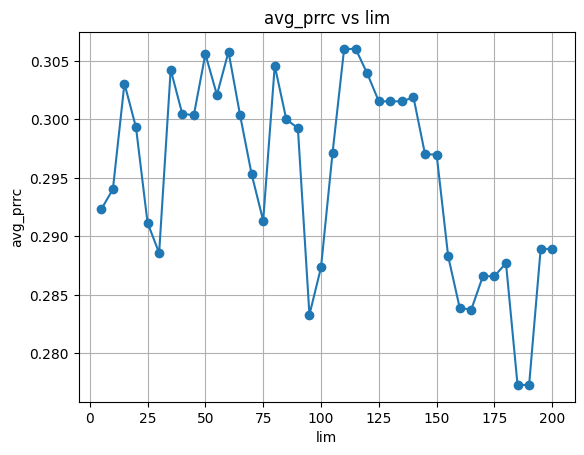

In [594]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [595]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [596]:
df_res = pd.DataFrame(results)

In [597]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.285292
26,135,0.285292
27,140,0.291544
28,145,0.283415
29,150,0.306418


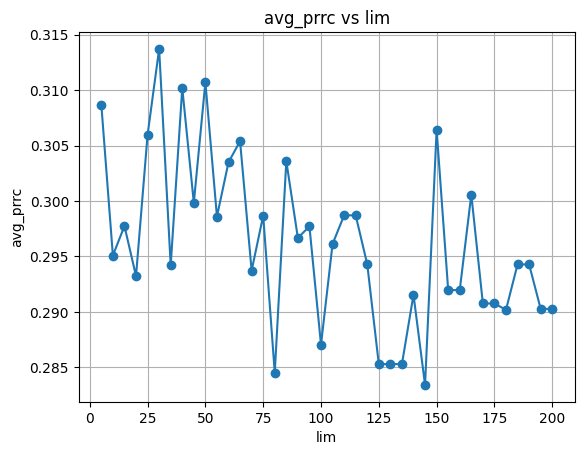

In [598]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [599]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [600]:
df_res = pd.DataFrame(results)

In [601]:
df_res[5:10]

,lim,avg_prrc
5,30,0.305537
6,35,0.306705
7,40,0.305548
8,45,0.297075
9,50,0.296559


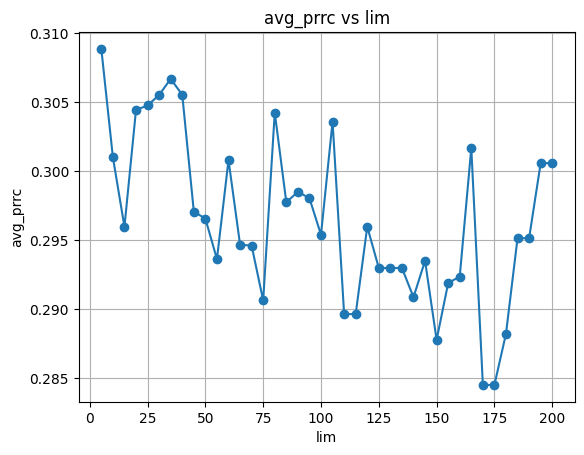

In [602]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [603]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [604]:
df_res = pd.DataFrame(results)

In [605]:
df_res[-5:]

,lim,avg_prrc
35,180,0.284461
36,185,0.289660
37,190,0.289660
38,195,0.303867
39,200,0.303867


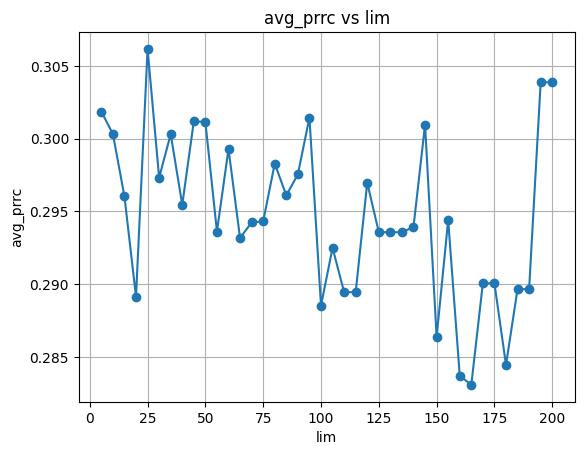

In [606]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# Tenth Experiment

In [607]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
        'fb_dob',
        'fb_relation',
        'fb_gender'
    ]].copy()

    df_bs.fb_gender = df_bs.fb_gender.fillna("unstated")
    
    df_bs.fb_relation = df_bs.fb_relation.fillna('Unstated')
    df_bs['pending_relation'] = df_bs.fb_relation.str.contains('Pending')
    df_bs.fb_relation = df_bs.fb_relation.str.replace(' (Pending)', '')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a civil union', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a domestic partnership', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('Separated', 'Divorced')

    df_bs['fb_age'] = ((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365
    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list', 'fb_dob'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier(
        # tree_method="hist",  # use histogram, works for both CPU and GPU
        # device="cuda:0"      # instead of gpu_id
    )
    model.fit(X_train, y_train)
    del X_train, y_train
    
    # y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_proba)
    }

In [608]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [609]:
df_res = pd.DataFrame(results)

In [610]:
df_res.head()

,lim,avg_prrc
0,5,0.305725
1,10,0.304432
2,15,0.301670
3,20,0.296348
4,25,0.294044


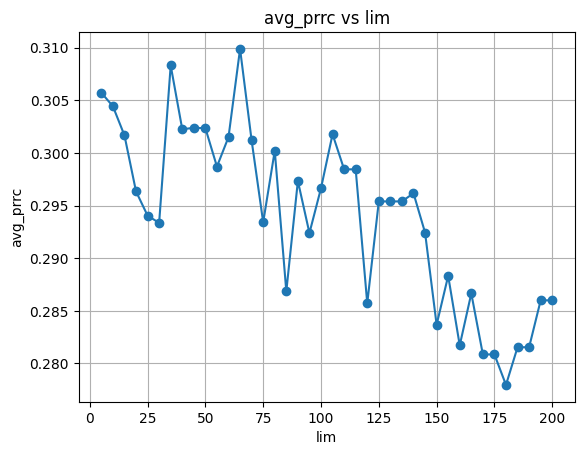

In [611]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [612]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [613]:
df_res = pd.DataFrame(results)

In [614]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.301779
26,135,0.301779
27,140,0.290423
28,145,0.293014
29,150,0.297192


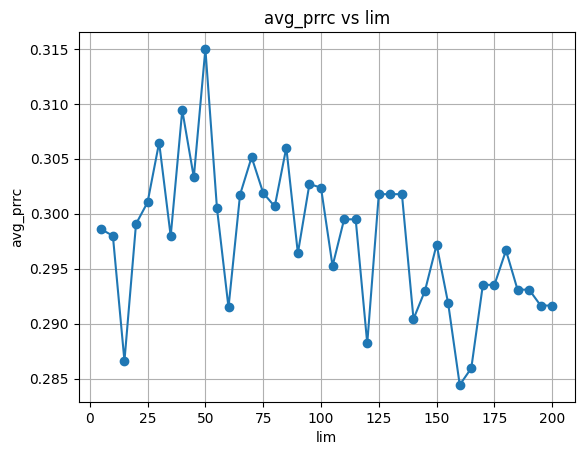

In [615]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [616]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [617]:
df_res = pd.DataFrame(results)

In [618]:
df_res[5:10]

,lim,avg_prrc
5,30,0.303872
6,35,0.307903
7,40,0.304242
8,45,0.304215
9,50,0.308854


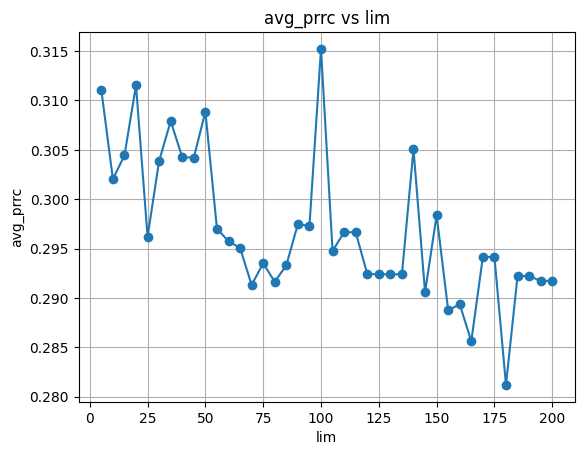

In [619]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [620]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [621]:
df_res = pd.DataFrame(results)

In [622]:
df_res[-5:]

,lim,avg_prrc
35,180,0.285342
36,185,0.298406
37,190,0.298406
38,195,0.292332
39,200,0.292332


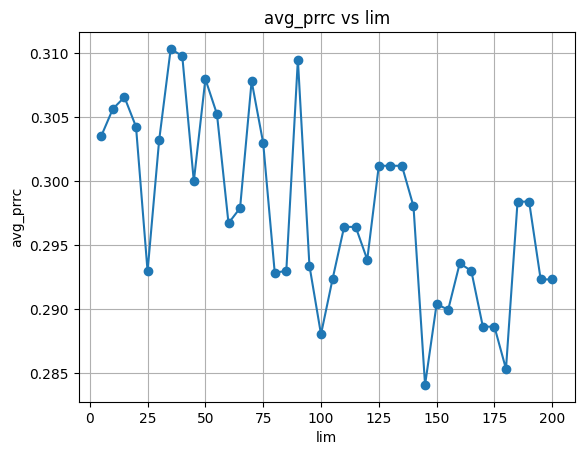

In [623]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# 11 | XGBoost scaled

In [624]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
        'fb_dob',
        'fb_relation',
        'fb_gender'
    ]].copy()

    df_bs.fb_gender = df_bs.fb_gender.fillna("unstated")
    
    df_bs.fb_relation = df_bs.fb_relation.fillna('Unstated')
    df_bs['pending_relation'] = df_bs.fb_relation.str.contains('Pending')
    df_bs.fb_relation = df_bs.fb_relation.str.replace(' (Pending)', '')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a civil union', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a domestic partnership', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('Separated', 'Divorced')

    df_bs['fb_age'] = ((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365
    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list', 'fb_dob'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    model = XGBClassifier(
        # tree_method="hist",  # use histogram, works for both CPU and GPU
        # device="cuda:0"      # instead of gpu_id
        scale_pos_weight=df.flag_bad.value_counts()[0]/df.flag_bad.value_counts()[1]
    )
    model.fit(X_train, y_train)
    del X_train, y_train
    
    # y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_proba)
    }

In [625]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [626]:
df_res = pd.DataFrame(results)

In [627]:
df_res.head()

,lim,avg_prrc
0,5,0.292261
1,10,0.304490
2,15,0.290119
3,20,0.291601
4,25,0.298734


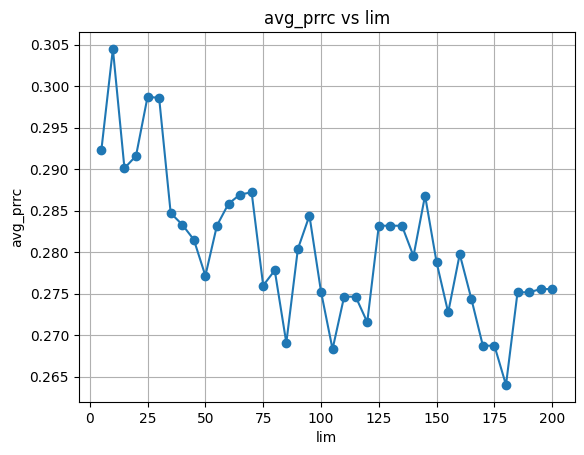

In [628]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [629]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [630]:
df_res = pd.DataFrame(results)

In [631]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.272096
26,135,0.272096
27,140,0.283906
28,145,0.272058
29,150,0.274738


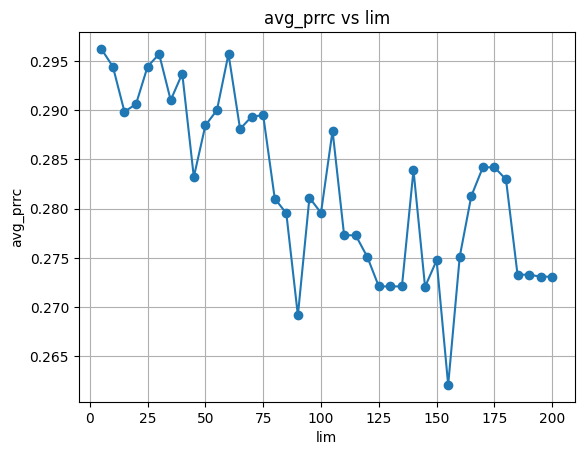

In [632]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [633]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [634]:
df_res = pd.DataFrame(results)

In [635]:
df_res[5:10]

,lim,avg_prrc
5,30,0.289406
6,35,0.292491
7,40,0.289432
8,45,0.284097
9,50,0.301352


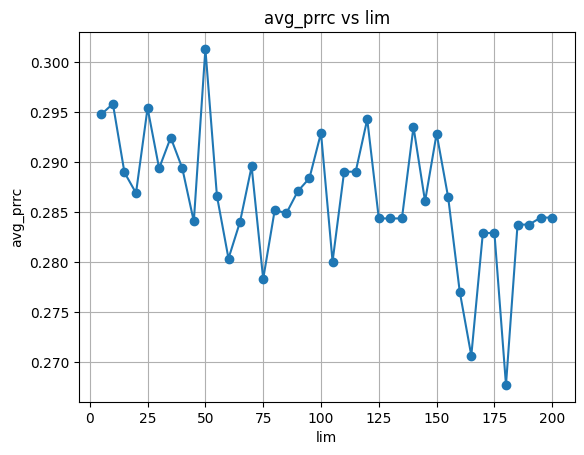

In [636]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [637]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [638]:
df_res = pd.DataFrame(results)

In [639]:
df_res[-5:]

,lim,avg_prrc
35,180,0.293032
36,185,0.283467
37,190,0.283467
38,195,0.279090
39,200,0.279090


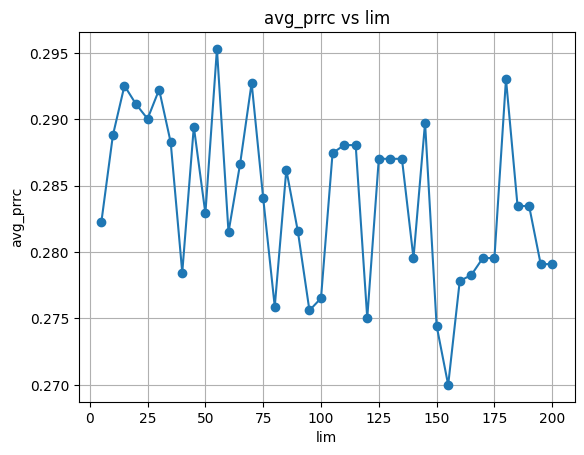

In [640]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# 12 | Smote

In [293]:
from imblearn.over_sampling import SMOTE

In [308]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
        'fb_dob',
        'fb_relation',
        'fb_gender'
    ]].copy()

    df_bs.fb_gender = df_bs.fb_gender.fillna("unstated")
    
    df_bs.fb_relation = df_bs.fb_relation.fillna('Unstated')
    df_bs['pending_relation'] = df_bs.fb_relation.str.contains('Pending')
    df_bs.fb_relation = df_bs.fb_relation.str.replace(' (Pending)', '')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a civil union', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a domestic partnership', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('Separated', 'Divorced')

    df_bs['fb_age'] = ((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365
    df_bs['fb_age'] = df_bs['fb_age'].fillna(df_bs['de_age'])
    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    df_bs["date_diff"] = df_bs["date_diff"].fillna(9999)
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list', 'fb_dob'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    del X, y
    
    smote = SMOTE(random_state=42)
    model = XGBClassifier(
        # tree_method="hist",  # use histogram, works for both CPU and GPU
        # device="cuda:0"      # instead of gpu_id
        # scale_pos_weight=df.flag_bad.value_counts()[0]/df.flag_bad.value_counts()[1]
    )
    X_res, y_res = smote.fit_resample(X_train, y_train)
    model.fit(X_res, y_res)
    del X_train, y_train, X_res, y_res
    
    # y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_proba)
    }

In [309]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [310]:
df_res = pd.DataFrame(results)

In [311]:
df_res.head()

,lim,avg_prrc
0,5,0.294289
1,10,0.288422
2,15,0.294401
3,20,0.290367
4,25,0.304849


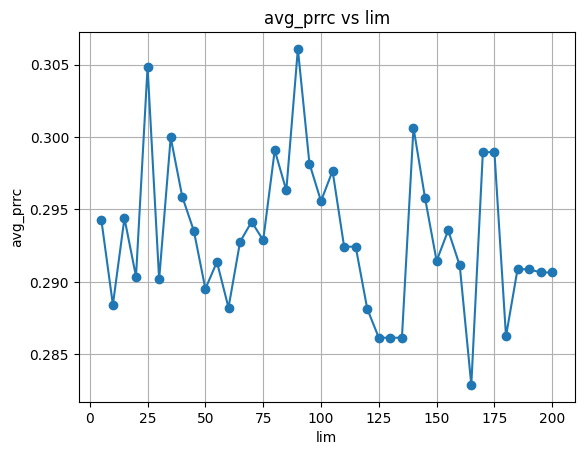

In [312]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [313]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [314]:
df_res = pd.DataFrame(results)

In [315]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.292860
26,135,0.292860
27,140,0.303829
28,145,0.282014
29,150,0.288024


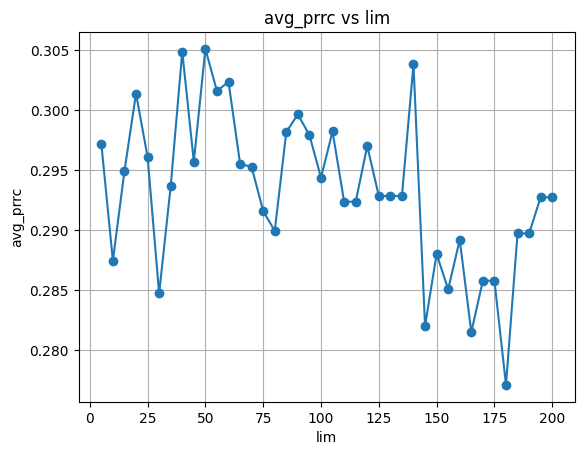

In [316]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [317]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [318]:
df_res = pd.DataFrame(results)

In [319]:
df_res[5:10]

,lim,avg_prrc
5,30,0.295574
6,35,0.290440
7,40,0.299140
8,45,0.300882
9,50,0.298503


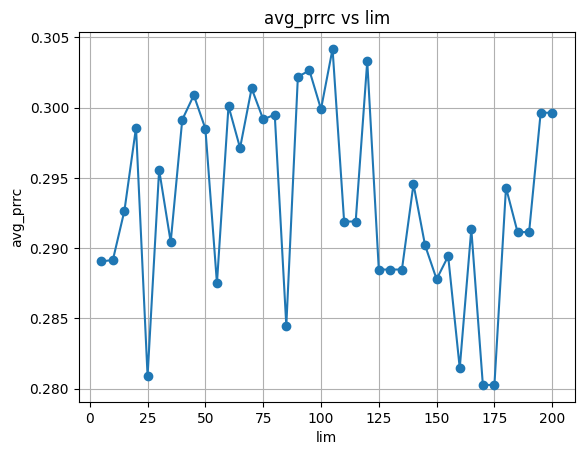

In [320]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# 13 | Stratify Y

In [641]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
        'fb_dob',
        'fb_relation',
        'fb_gender'
    ]].copy()

    df_bs.fb_gender = df_bs.fb_gender.fillna("unstated")
    
    df_bs.fb_relation = df_bs.fb_relation.fillna('Unstated')
    df_bs['pending_relation'] = df_bs.fb_relation.str.contains('Pending')
    df_bs.fb_relation = df_bs.fb_relation.str.replace(' (Pending)', '')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a civil union', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a domestic partnership', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('Separated', 'Divorced')

    df_bs['fb_age'] = ((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365
    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list', 'fb_dob'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    del X, y
    
    model = XGBClassifier(
        # tree_method="hist",  # use histogram, works for both CPU and GPU
        # device="cuda:0"      # instead of gpu_id
    )
    model.fit(X_train, y_train)
    del X_train, y_train
    
    # y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_proba)
    }

In [642]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [643]:
df_res = pd.DataFrame(results)

In [644]:
df_res.head()

,lim,avg_prrc
0,5,0.294861
1,10,0.311396
2,15,0.302589
3,20,0.305058
4,25,0.305154


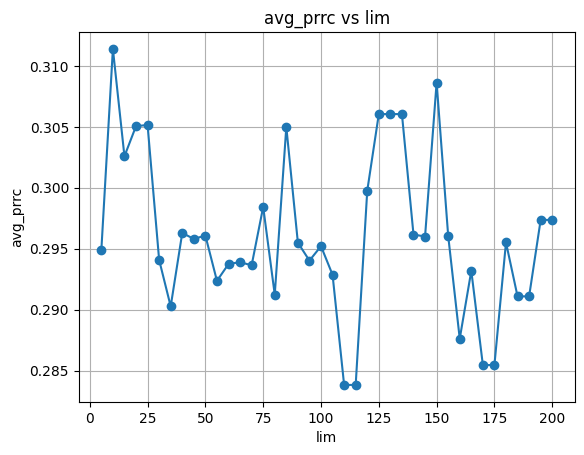

In [645]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [646]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [647]:
df_res = pd.DataFrame(results)

In [648]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.298450
26,135,0.298450
27,140,0.297170
28,145,0.291088
29,150,0.290508


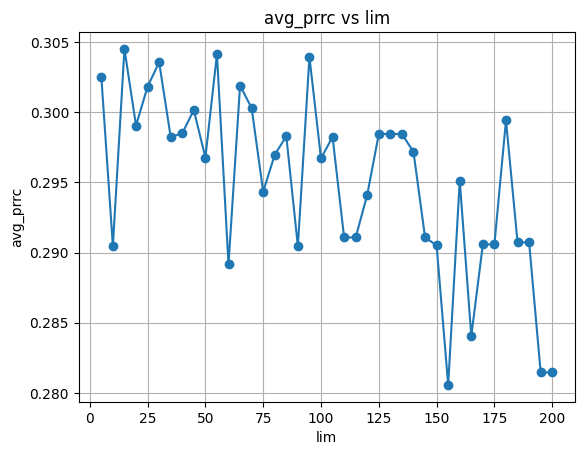

In [649]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [650]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [651]:
df_res = pd.DataFrame(results)

In [652]:
df_res[5:10]

,lim,avg_prrc
5,30,0.301375
6,35,0.299674
7,40,0.297847
8,45,0.300741
9,50,0.289648


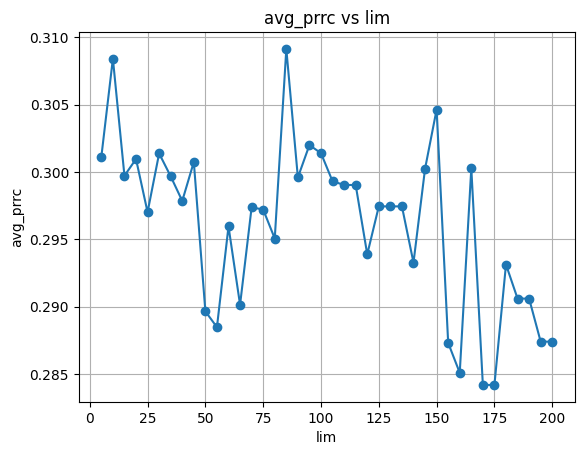

In [653]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [654]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [655]:
df_res = pd.DataFrame(results)

In [656]:
df_res[-5:]

,lim,avg_prrc
35,180,0.289771
36,185,0.281003
37,190,0.281003
38,195,0.293173
39,200,0.293173


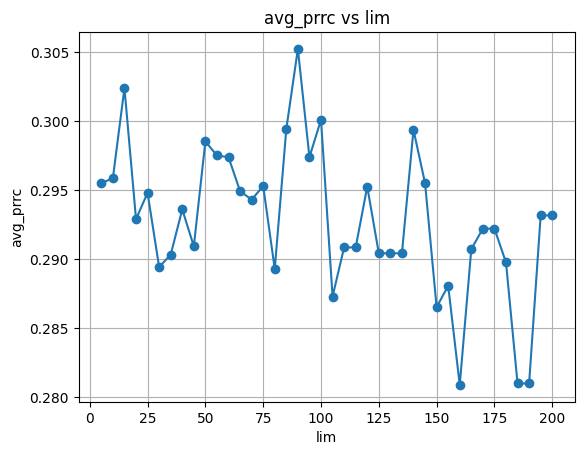

In [657]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# 13 | Feature Engineering: Device

## Price

In [57]:
df_mkt_gsm = pd.read_csv('marketing_gsm_clean.csv')
df_mkt_gsm

,device_codename,brand,Retail Branding,Marketing Name,Device,oem,model,network_technology,network_2g_bands,network_gprs,...,main_camera_dual_or_triple,battery_music_play,selfie_camera_triple,main_camera_v1,selfie_camera,camera,main_camera,network,battery_talk_time,battery_stand.by
0,HM2014817,Xiaomi,Xiaomi,Redmi 2,HM2014817,Xiaomi,Redmi 2,GSM / HSPA / LTE,GSM 900 / 1800 / 1900 - SIM 1 & SIM 2,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TD-SCDMA,NaN,NaN
1,A1601,OPPO,Oppo,F1s,A1601,Oppo,F1s,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LTE band 1(2100), 3(1800), 5(850), 40(2300) - ...",NaN,NaN
2,1609,vivo,Vivo,V5 Lite (vivo 1609),1609,Vivo,V5 Lite (vivo 1609),GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,a5xelte,samsung,Samsung,Galaxy A5 (2016),a5xelte,Samsung,Galaxy A5 (2016),GSM / UMTS / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2 (d...,Yes,...,NaN,Up to 75 h,NaN,NaN,NaN,NaN,NaN,UMTS 2100,Up to 16 h (3G),NaN
4,mlv5,lge,LG,K10 (2017),mlv5,LG,K10 (2017),GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2 (d...,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LTE band 3(1800), 5(850), 40(2300) - India",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,F02H,DOCOMO,Fujitsu,F-02H,F02H,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1054,1723CF,vivo,Vivo,V9 6GB,NaN,Vivo,V9 6GB,GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2,Yes,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1055,POLYTRON,POLYTRON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1056,M24i,HIMAX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
df_mkt_gsm.misc_price.value_counts()

misc_price
About 130 EUR                                       54
About 300 EUR                                       54
About 250 EUR                                       52
About 200 EUR                                       37
About 150 EUR                                       32
About 160 EUR                                       28
About 400 EUR                                       28
About 270 EUR                                       27
About 140 EUR                                       26
About 190 EUR                                       26
About 100 EUR                                       24
About 120 EUR                                       23
About 180 EUR                                       23
About 280 EUR                                       22
About 110 EUR                                       21
About 230 EUR                                       20
About 170 EUR                                       20
About 290 EUR                                       19

In [59]:
df_mkt_gsm[df_mkt_gsm.misc_price=='<c2><a3><e2><80><89>141.60 / $<e2><80><89>149.00']

,device_codename,brand,Retail Branding,Marketing Name,Device,oem,model,network_technology,network_2g_bands,network_gprs,...,main_camera_dual_or_triple,battery_music_play,selfie_camera_triple,main_camera_v1,selfie_camera,camera,main_camera,network,battery_talk_time,battery_stand.by
685,vince,xiaomi,Xiaomi,Redmi 5 Plus (Redmi Note 5),NaN,Xiaomi,Redmi 5 Plus (Redmi Note 5),GSM / HSPA / LTE,GSM 850 / 900 / 1800 / 1900 - SIM 1 & SIM 2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"1, 3, 5, 40, 41 - India",NaN,NaN


In [60]:
# Change with real price from the gsmarena page
df_mkt_gsm.misc_price = df_mkt_gsm.misc_price.replace({'<c2><a3><e2><80><89>141.60 / $<e2><80><89>149.00':'About 180 EUR'})

In [61]:
df_mkt_gsm.misc_price.value_counts()

misc_price
About 130 EUR     54
About 300 EUR     54
About 250 EUR     52
About 200 EUR     37
About 150 EUR     32
About 160 EUR     28
About 400 EUR     28
About 270 EUR     27
About 140 EUR     26
About 190 EUR     26
About 180 EUR     24
About 100 EUR     24
About 120 EUR     23
About 280 EUR     22
About 110 EUR     21
About 230 EUR     20
About 170 EUR     20
About 290 EUR     19
About 220 EUR     18
About 320 EUR     17
About 260 EUR     15
About 350 EUR     15
About 90 EUR      13
About 330 EUR     13
About 210 EUR     12
About 240 EUR     11
About 340 EUR     10
About 380 EUR     10
About 420 EUR     10
About 390 EUR      9
About 470 EUR      9
About 360 EUR      8
About 70 EUR       7
About 550 EUR      7
About 80 EUR       6
About 310 EUR      5
About 500 EUR      5
About 450 EUR      4
About 440 EUR      4
About 370 EUR      4
About 430 EUR      3
About 690 EUR      3
About 60 EUR       3
About 50 EUR       2
About 620 EUR      2
About 530 EUR      2
About 490 EUR      1
Ab

In [62]:
df_mkt_gsm.misc_price = df_mkt_gsm.misc_price.str.extract(r"(\d+)")

In [63]:
df_device = pd.read_csv('device_info.csv')

In [64]:
a = df_device[df_device == df_mkt_gsm[['device_codename', 'brand']]]
a[a.brand.isna()]

,device_codename,brand


In [83]:
df_mkt_gsm['Marketing Name'].value_counts()

Marketing Name
Galaxy S7 edge      12
Galaxy Note 4        9
Galaxy S7            8
Galaxy S5            8
Galaxy S6 edge       6
                    ..
4C                   1
Enjoy 5s             1
S90 Sisley           1
Galaxy J1 (2016)     1
X3                   1
Name: count, Length: 655, dtype: int64

In [66]:
def mini_exp_device(lim, filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
        'fb_dob',
        'fb_relation',
        'fb_gender'
    ]].copy()

    df_bs.fb_gender = df_bs.fb_gender.fillna("unstated")
    
    df_bs.fb_relation = df_bs.fb_relation.fillna('Unstated')
    df_bs['pending_relation'] = df_bs.fb_relation.str.contains('Pending')
    df_bs.fb_relation = df_bs.fb_relation.str.replace(' (Pending)', '')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a civil union', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a domestic partnership', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('Separated', 'Divorced')

    df_bs['fb_age'] = ((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365
    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device

    df_mkt_gsm = pd.read_csv('marketing_gsm_clean.csv')
    df_mkt_gsm = df_mkt_gsm[[
        'device_codename',
        'brand',
        'misc_price'
    ]]
    df_mkt_gsm.misc_price = df_mkt_gsm.misc_price.replace({'<c2><a3><e2><80><89>141.60 / $<e2><80><89>149.00':'About 180 EUR'})
    df_mkt_gsm.misc_price = df_mkt_gsm.misc_price.str.extract(r"(\d+)")
    df_bs = df_bs.merge(df_mkt_gsm, how='left', on=['device_codename', 'brand'])
    
    counts = df_bs["device_codename"].value_counts()
    df_bs["device_codename_grouped"] = df_bs["device_codename"].apply(
        lambda x: x if counts[x] > lim else "others"
    )
    del counts

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list', 'fb_dob'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    del X, y
    
    model = XGBClassifier(
        # tree_method="hist",  # use histogram, works for both CPU and GPU
        # device="cuda:0"      # instead of gpu_id
    )
    model.fit(X_train, y_train)
    del X_train, y_train
    
    # y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    del X_test

    return {
        "lim": lim,
        "avg_prrc": average_precision_score(y_test, y_proba)
    }

In [67]:
results = [mini_exp_device(i, filler='zero') for i in range(5,205,5)]

In [68]:
df_res = pd.DataFrame(results)

In [69]:
df_res.head()

,lim,avg_prrc
0,5,0.302742
1,10,0.311596
2,15,0.303962
3,20,0.294360
4,25,0.292648


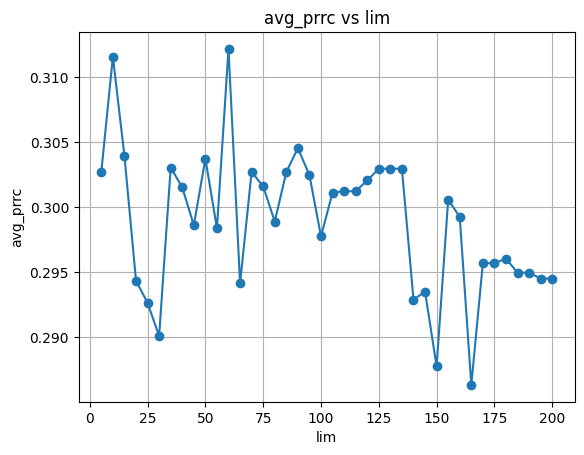

In [70]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [71]:
results = [mini_exp_device(i, filler='median') for i in range(5,205,5)]

In [72]:
df_res = pd.DataFrame(results)

In [73]:
df_res[-15:-10]

,lim,avg_prrc
25,130,0.289079
26,135,0.289079
27,140,0.297115
28,145,0.294544
29,150,0.293022


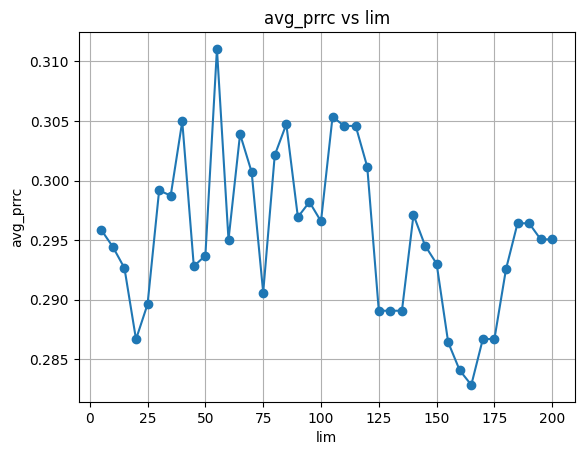

In [74]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [75]:
results = [mini_exp_device(i, filler='-1') for i in range(5,205,5)]

In [76]:
df_res = pd.DataFrame(results)

In [77]:
df_res[5:10]

,lim,avg_prrc
5,30,0.290773
6,35,0.304033
7,40,0.295957
8,45,0.297651
9,50,0.295189


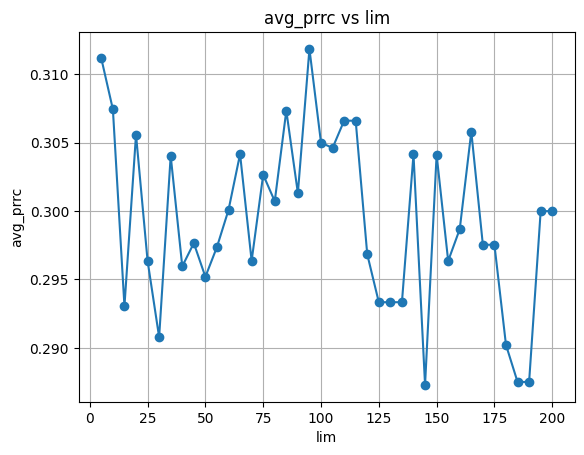

In [78]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

In [79]:
results = [mini_exp_device(i, filler='nan') for i in range(5,205,5)]

In [80]:
df_res = pd.DataFrame(results)

In [81]:
df_res[-5:]

,lim,avg_prrc
35,180,0.285620
36,185,0.291860
37,190,0.291860
38,195,0.291838
39,200,0.291838


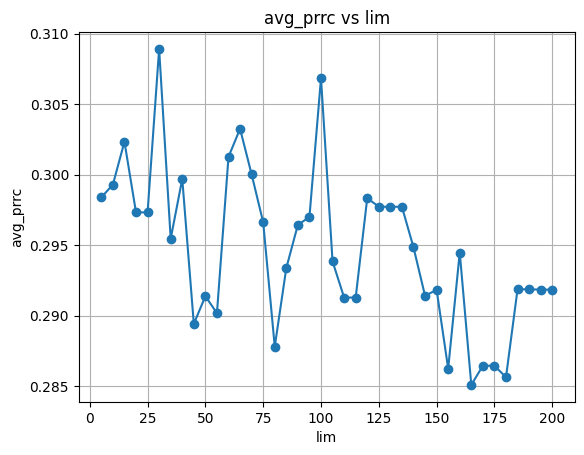

In [82]:
plt.plot(df_res["lim"], df_res["avg_prrc"], marker="o")

plt.xlabel("lim")
plt.ylabel("avg_prrc")
plt.title("avg_prrc vs lim")
plt.grid(True)
plt.show()

# 14 | Without Phone Category

In [127]:
df_mkt_gsm.platform_os.value_counts()[:50]

platform_os
Android 5.1 (Lollipop)                                                                        28
Android 4.4.2 (KitKat)                                                                        27
Android 6.0 (Marshmallow)                                                                     27
Android 6.0 (Marshmallow), upgradable to Android 8.0 (Oreo); TouchWiz UI                      20
Android 6.0.1 (Marshmallow), upgradable to Android 8.0 (Oreo)                                 18
Android 4.2.2 (Jelly Bean)                                                                    15
Android 7.0 (Nougat)                                                                          15
Android 4.4.4 (KitKat), upgradable to 6.0 (Marshmallow)                                       14
Android 5.1.1 (Lollipop), upgradable to 7.0 (Nougat)                                          13
Android 4.4.4 (KitKat), upgradable to 6.0.1 (Marshmallow)                                     13
Android 4.2 (Jelly

In [125]:
texts = [
    "Android 5.1 (Lollipop)",
    "Android 4.4.2 (KitKat)",
    "Android 7.1.2 (Nougat); MIUI 10",
    "Android 4.4.4 (KitKat), upgradable to 5.1.1 (Lollipop)",
    "iOS 9, upgradable to iOS 12.2",
    "Android 5.1.1 (Lollipop) or Android 6.0 (Marshmallow), upgradable to 7.1.1 (Nougat)",
    "Android 4.2 (Jelly Bean)Android 4.4.4 (KitKat) - GT-I9060I"
]

pattern = re.compile(r'^(Android\s[\d.]+(?:\s*\([^)]*\))?|iOS\s[\d.]+(?:\s*\([^)]*\))?)')

for t in texts:
    m = pattern.search(t)
    print(t, "→", m.group(0) if m else None)

Android 5.1 (Lollipop) → Android 5.1 (Lollipop)
Android 4.4.2 (KitKat) → Android 4.4.2 (KitKat)
Android 7.1.2 (Nougat); MIUI 10 → Android 7.1.2 (Nougat)
Android 4.4.4 (KitKat), upgradable to 5.1.1 (Lollipop) → Android 4.4.4 (KitKat)
iOS 9, upgradable to iOS 12.2 → iOS 9
Android 5.1.1 (Lollipop) or Android 6.0 (Marshmallow), upgradable to 7.1.1 (Nougat) → Android 5.1.1 (Lollipop)
Android 4.2 (Jelly Bean)Android 4.4.4 (KitKat) - GT-I9060I → Android 4.2 (Jelly Bean)


In [116]:
df_mkt_gsm.platform_os.str.extract(r'^(Android\s[\d.]+(?:\s*\([^)]*\))?|iOS\s[\d.]+(?:\s*\([^)]*\))?)').value_counts()

0                                 
Android 6.0 (Marshmallow)             84
Android 4.4.2 (KitKat)                76
Android 5.1 (Lollipop)                64
Android 4.4.4 (KitKat)                60
Android 6.0.1 (Marshmallow)           57
Android 7.0 (Nougat)                  49
Android 5.1.1 (Lollipop)              47
Android 5.0 (Lollipop)                44
Android 4.3 (Jelly Bean)              33
Android 4.2.2 (Jelly Bean)            31
Android 7.1.1 (Nougat)                25
Android 4.2 (Jelly Bean)              23
Android 5.0.2 (Lollipop)              20
Android 4.1.2 (Jelly Bean)            19
Android 7.1 (Nougat)                  18
Android 8.0 (Oreo)                    15
Android 5.0.1 (Lollipop)              15
Android 8.1 (Oreo)                    15
Android 6 (Marshmallow)               14
Android 7.1.2 (Nougat)                12
Android 4.4 (KitKat)                   9
Android 4.1 (Jelly Bean)               7
Android 7 (Nougat)                     7
iOS 7                 

In [122]:
def normalize_os(os_str):
    if os_str is np.nan:
        return None
    
    # Detect Android
    if os_str.startswith("Android"):
        match = re.search(r"Android\s(\d+)(?:\.(\d+))?", os_str)
        if match:
            major = int(match.group(1))
            minor = match.group(2)
            
            # Map buckets
            if major == 4 and minor in ["0","1","2","3"]:
                return "Android 4 (Jelly Bean/ICS)"
            elif major == 4 and minor == "4":
                return "Android 4.4 (KitKat)"
            elif major == 5:
                return "Android 5 (Lollipop)"
            elif major == 6:
                return "Android 6 (Marshmallow)"
            elif major == 7:
                return "Android 7 (Nougat)"
            elif major == 8:
                return "Android 8 (Oreo)"
            elif major == 9:
                return "Android 9 (Pie)"
            elif major < 4:
                return "Android Legacy (<4)"
            else:
                return f"Android {major}"
    
    # Detect iOS
    if os_str.startswith("iOS"):
        match = re.search(r"iOS\s(\d+)", os_str)
        if match:
            return f"iOS {match.group(1)}"
    
    return os_str

In [124]:
df_mkt_gsm.platform_os.map(normalize_os).value_counts()

platform_os
Android 5 (Lollipop)          196
Android 6 (Marshmallow)       159
Android 4.4 (KitKat)          148
Android 4 (Jelly Bean/ICS)    127
Android 7 (Nougat)            111
Android 8 (Oreo)               33
iOS 7                           6
iOS 10                          5
Android Legacy (<4)             4
iOS 9                           3
iOS 8                           2
iOS 6                           2
Android 9 (Pie)                 2
iOS 11                          1
Name: count, dtype: int64

In [142]:
def normalize_os(os_str):
    if os_str is np.nan:
        return None
    
    # --- Android ---
    if os_str.startswith("Android"):
        match = re.search(r"Android\s(\d+)(?:\.(\d+))?", os_str)
        if match:
            major = int(match.group(1))
            minor = match.group(2)

            if major < 4:
                return "Android Legacy (less than 4)"
            elif major == 4:
                if minor in ["0", "1", "2", "3"]:
                    return "Android 4 (Jelly Bean/ICS)"
                elif minor == "4":
                    return "Android 4.4 (KitKat)"
                else:
                    return "Android 4 (Jelly Bean/ICS)"  # fallback
            elif major == 5:
                return "Android 5 (Lollipop)"
            elif major == 6:
                return "Android 6 (Marshmallow)"
            elif major == 7:
                return "Android 7 (Nougat)"
            elif major >= 8:
                return "Android 8+ (Oreo & later)"
    
    # --- iOS ---
    if os_str.startswith("iOS"):
        match = re.search(r"iOS\s(\d+)", os_str)
        if match:
            major = int(match.group(1))
            if major in [6, 7]:
                return "iOS 6-7"
            elif major in [8, 9]:
                return "iOS 8-9"
            elif major >= 10:
                return "iOS 10+"
    
    return "Other/Unknown"

In [143]:
df_mkt_gsm.platform_os.map(normalize_os).value_counts()

platform_os
Android 5 (Lollipop)            196
Android 6 (Marshmallow)         159
Android 4.4 (KitKat)            148
Android 4 (Jelly Bean/ICS)      127
Android 7 (Nougat)              111
Android 8+ (Oreo & later)        35
iOS 6-7                           8
iOS 10+                           6
iOS 8-9                           5
Android Legacy (less than 4)      4
Name: count, dtype: int64

Fraudster can use discontinued phones

In [169]:
df_mkt_gsm.launch_status.str.contains("Discontinued|Cancelled", case=False)

0       False
1       False
2       False
3       False
4       False
        ...  
1053      NaN
1054    False
1055      NaN
1056      NaN
1057    False
Name: launch_status, Length: 1058, dtype: object

Remember this is 2017 and past, where dual sim is new

In [201]:
df_mkt_gsm.body_sim.str.contains('Dual|Triple', case=False).value_counts()

body_sim
True     543
False    256
Name: count, dtype: int64

In [202]:
def mini_exp_device(filler):
    df_bs = df[[
        'flag_bad',
        'de_age',
        'de_gender',
        'de_num_friends',
        'de_monthly_salary',
        'de_employment_type',
        'de_employment_duration',
        'de_education',
        'de_marital_status',
        'de_children',
        'ph_call_log_stats',
        'ph_total_contacts',
        'de_date_joined',
        'fb_last_updated_date',
        'ph_app_list',
        'fb_dob',
        'fb_relation',
        'fb_gender'
    ]].copy()

    df_bs.fb_gender = df_bs.fb_gender.fillna("unstated")
    
    df_bs.fb_relation = df_bs.fb_relation.fillna('Unstated')
    df_bs['pending_relation'] = df_bs.fb_relation.str.contains('Pending')
    df_bs.fb_relation = df_bs.fb_relation.str.replace(' (Pending)', '')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a civil union', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('In a domestic partnership', 'Married')
    df_bs.fb_relation = df_bs.fb_relation.str.replace('Separated', 'Divorced')

    df_bs['fb_age'] = ((pd.to_datetime(df.de_date_joined, dayfirst=True) - pd.to_datetime(df.fb_dob))/pd.Timedelta(days=1))/365
    categories = {
        "gambling": ['casino', 'togel', 'prediksi', 'blackjack', 'jitu', 'mangosoft', 'zynga', 'gamble', 'dewa', 'jackpot', 'vegas', 'totolotto', 'slot', 'newflashbingo', 'luckywheel', 'roulette', 'poker', 'bingo', 'rummy', '777', '888'],
        "clone": ["clone", "dual", "parallel", "multi" , "whatscan"],
        "modded": ["mod", "hack", "vip", "apk", "patched", "crack", "cheat", "unlocked","premiumfree","vipmod","luckypatcher"],
        "finance_risky": ['loan', 'pinjam', 'tunai', 'uang', 'moneyapp', 'rupiah', 'cash', 'duit', 'kredit', 'modalku', 'julo', 'payday', 'cicil'],
        "invest": ['stockbit', 'forex', 'mirae', 'coinbase', 'binance', 'saham'],
        "adult": ['michat', 'tinder', 'bigolivegirlvideo', 'okcupid', "live", "cam", "dating", "xxx", "sexy", "hot", "escort", "porn"],
        "suspicious_utility": ['fake', 'anony', "booster", "cleaner", "locker", "battery", "optimizer", "antivirusfree", "speedup", "vpn"],
    }
    
    # Create binary columns for each category
    for cat, keywords in categories.items():
        df_bs[cat] = df_bs["ph_app_list"].str.lower().apply(
            lambda x: int(any(kw in x for kw in keywords))
        )
    
    joined = pd.to_datetime(df_bs.de_date_joined, dayfirst=True, errors="coerce").dt.tz_localize("Asia/Jakarta")
    updated = pd.to_datetime(df_bs.fb_last_updated_date, errors="coerce")
    
    df_bs["date_diff"] = ((joined - updated) / pd.Timedelta(days=1))
    del joined, updated
    
    df_device = df["ph_other_device_info"].apply(json.loads).apply(pd.Series)
    df_bs = pd.concat([df_bs, df_device], axis=1)
    del df_device

    df_mkt_gsm = pd.read_csv('marketing_gsm_clean.csv')
    df_mkt_gsm = df_mkt_gsm[[
        'device_codename',
        'brand',
        'misc_price',
        'platform_os',
        'launch_status',
        'body_sim',
    ]]
    df_mkt_gsm.misc_price = df_mkt_gsm.misc_price.replace({'<c2><a3><e2><80><89>141.60 / $<e2><80><89>149.00':'About 180 EUR'})
    df_mkt_gsm.misc_price = df_mkt_gsm.misc_price.str.extract(r"(\d+)")
    df_mkt_gsm.platform_os = df_mkt_gsm.platform_os.map(normalize_os)
    df_mkt_gsm["discontinued"] = df_mkt_gsm.launch_status.str.contains("Discontinued|Cancelled", case=False)
    df_mkt_gsm.body_sim = df_mkt_gsm.body_sim.str.contains('Dual|Triple', case=False)
    df_bs = df_bs.merge(df_mkt_gsm, how='left', on=['device_codename', 'brand'])

    df_call_log_stats = df["ph_call_log_stats"].apply(lambda x: json.loads(x) if isinstance(x, str) else {}).apply(pd.Series)
    options = {
        "median": df_call_log_stats.median(),
        "zero": 0,
        "-1": -1,
        "nan": np.nan
    }
    filler_value = options.get(filler)
    df_call_log_stats = df_call_log_stats.fillna(filler_value)
    df_bs = pd.concat([df_bs, df_call_log_stats], axis=1)
    del df_call_log_stats
    
    df_bs = df_bs.drop(['brand', 'device_codename', 'ph_call_log_stats', 'de_date_joined', 'fb_last_updated_date', 'ph_app_list', 'fb_dob', 'launch_status'], axis=1)

    df_bs.de_employment_type = df_bs.de_employment_type.replace(4,3)
    
    df_bs.de_gender = df_bs.de_gender.astype(str)
    df_bs.de_employment_type = df_bs.de_employment_type.astype(str)
    df_bs.de_education = df_bs.de_education.astype(str)
    df_bs.de_marital_status = df_bs.de_marital_status.astype(str)
    df_bs.de_children = df_bs.de_children.astype(str)
    
    df_bs = pd.get_dummies(df_bs)
    
    y = df_bs.flag_bad
    X = df_bs.drop('flag_bad', axis=1)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    del X, y
    
    model = XGBClassifier(
        # tree_method="hist",  # use histogram, works for both CPU and GPU
        # device="cuda:0"      # instead of gpu_id
    )
    model.fit(X_train, y_train)
    del X_train, y_train
    
    # y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    del X_test

    return {
        "avg_prrc": average_precision_score(y_test, y_proba)
    }

In [203]:
mini_exp_device(filler='zero')

{'avg_prrc': 0.2975730847523364}

In [204]:
mini_exp_device(filler='median')

{'avg_prrc': 0.281787338142007}

In [205]:
mini_exp_device(filler='-1')

{'avg_prrc': 0.28074632048072806}

In [206]:
mini_exp_device(filler='nan')

{'avg_prrc': 0.28313905114596233}

# EDA